In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [55]:
from __future__ import division
import argparse
import os
from datetime import datetime
import atari_py
import numpy as np
import torch
import wandb

from agent import Agent
from env import Env
from memory import ReplayMemory
from tqdm import tqdm, trange
import pickle
import bz2

import matplotlib
import matplotlib.pyplot as plt
import cv2

### Repeating arg-parse args just to make my life easier

In [20]:
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)

_StoreAction(option_strings=['--memory-save-folder'], dest='memory_save_folder', nargs=None, const=None, default='/misc/vlgscratch4/LakeGroup/guy/rainbow_memory', type=None, choices=None, help=None, metavar=None)

In [21]:
args = parser.parse_args([])

np.random.seed(args.seed)
# TODO: why not just fix the torch seed to the same one as np?
# torch.manual_seed(np.random.randint(1, 10000))
torch.manual_seed(args.seed)

if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  # torch.cuda.manual_seed(np.random.randint(1, 10000))
  torch.cuda.manual_seed(args.seed)
  torch.backends.cudnn.enabled = args.enable_cudnn
else:
  args.device = torch.device('cpu')

args.evaluation_size = 20
args.game = 'frostbite'

### Create the environment

In [22]:
env = Env(args)
env.train()
action_space = env.action_space()

### Use random frame samples to test out the flow

In [66]:
farneback_params = {
    'pyr_scale': 0.5,
    'levels': 3,
    'winsize': 5, # 15,
    'iterations': 7, # 3,
    'poly_n': 3, # 5,
    'poly_sigma': 0.8, # 1.2,
    'flags': 0, # cv2.OPTFLOW_USE_INITIAL_FLOW
}

FLOW_TOLERANCE = 1e-5

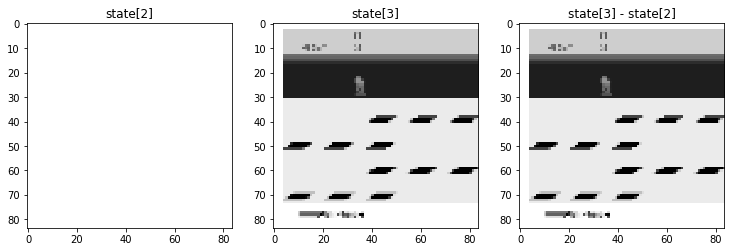

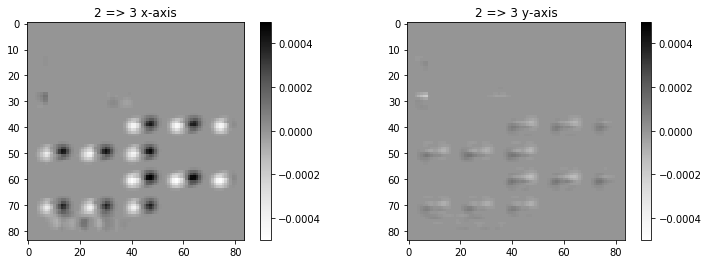

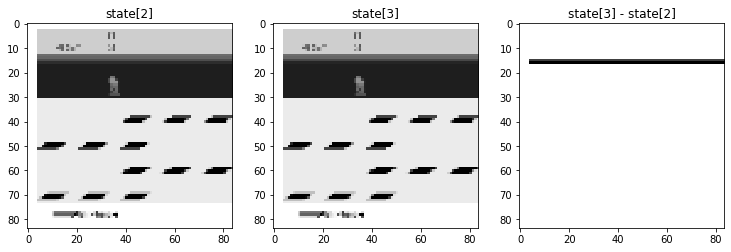

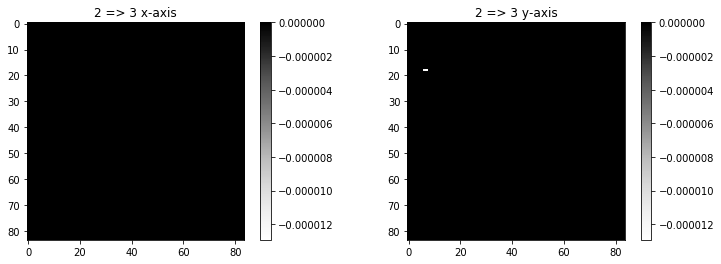

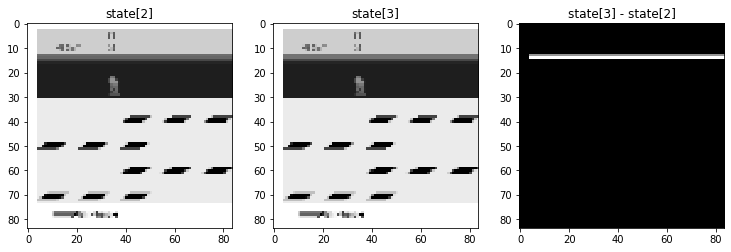

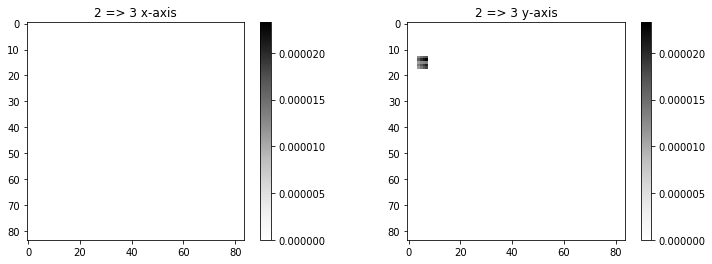

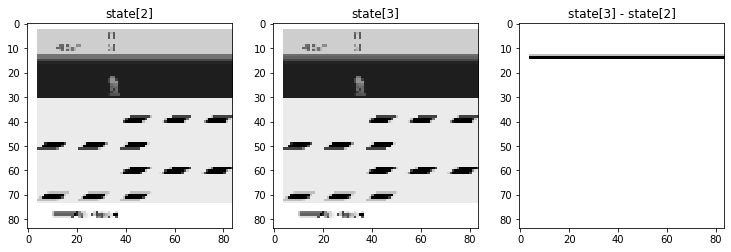

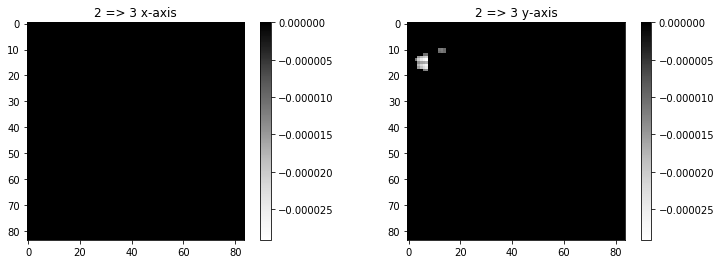

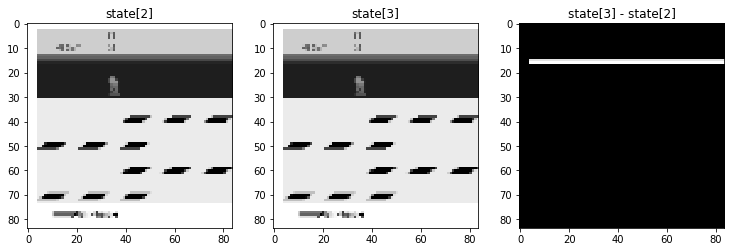

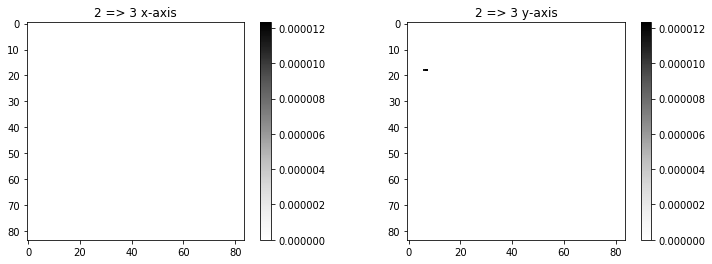

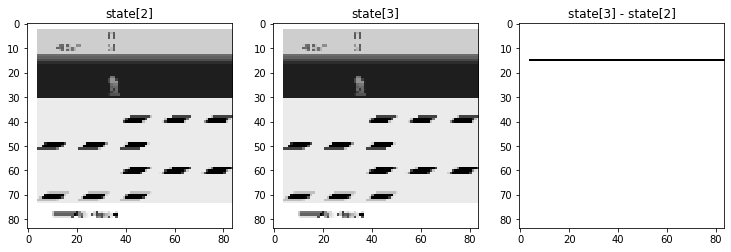

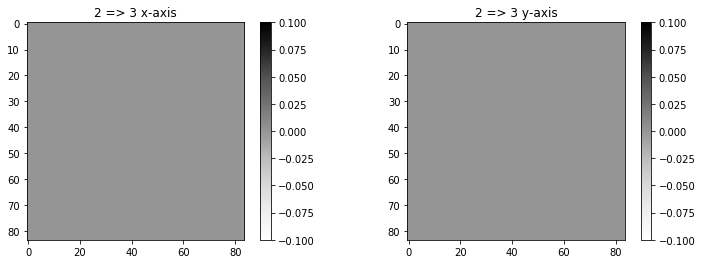

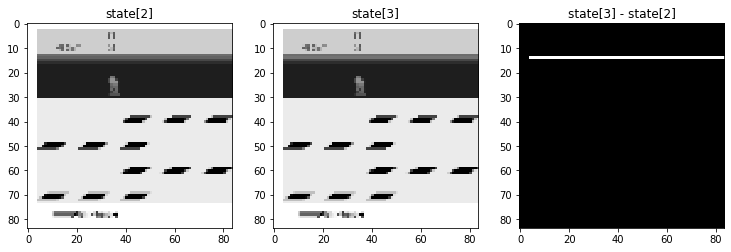

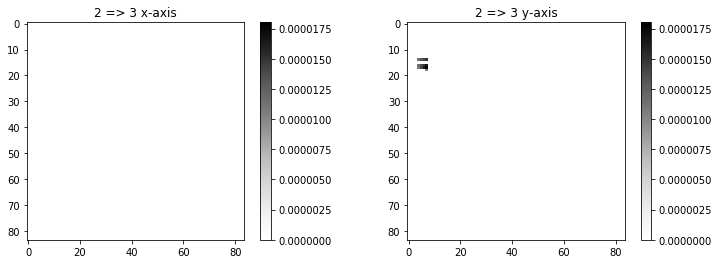

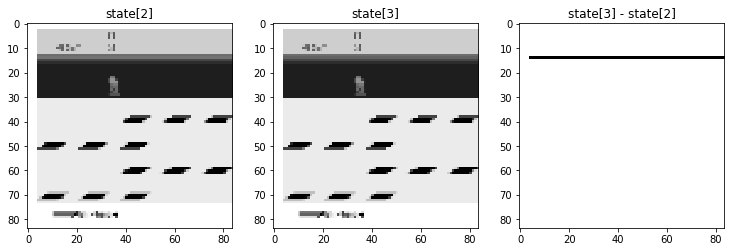

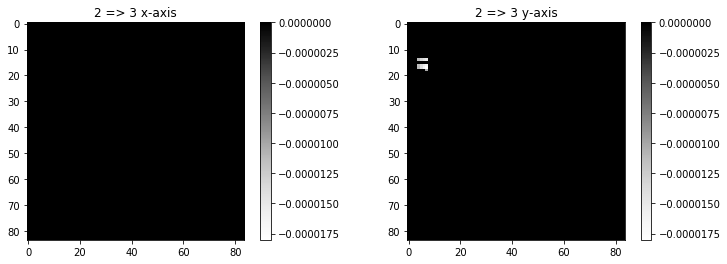

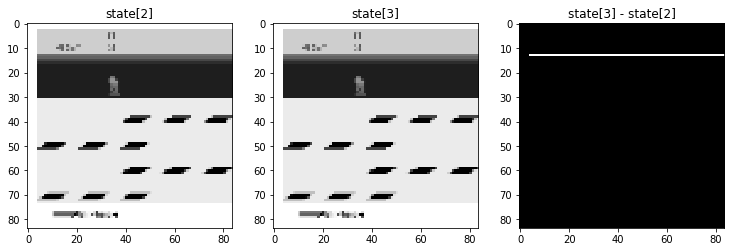

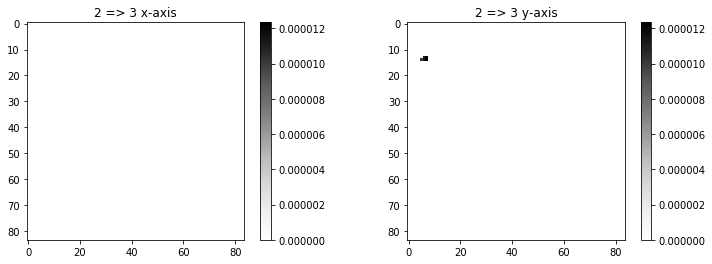

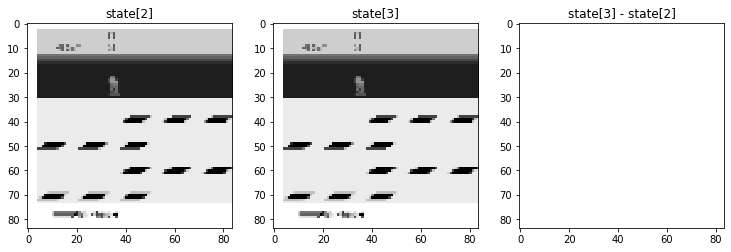

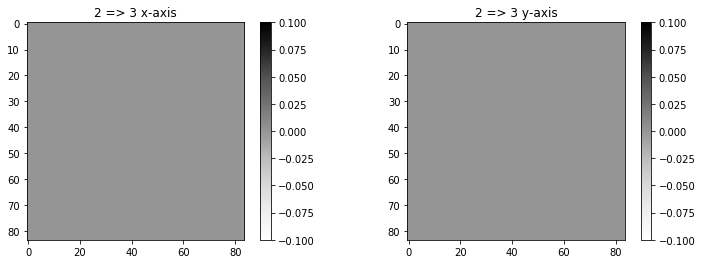

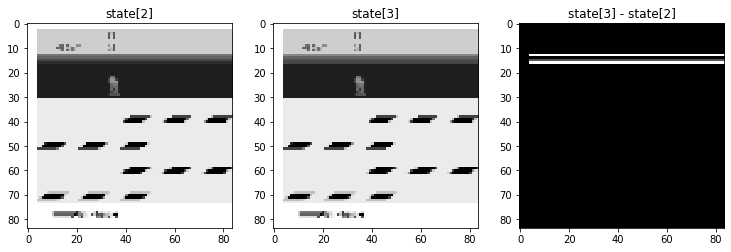

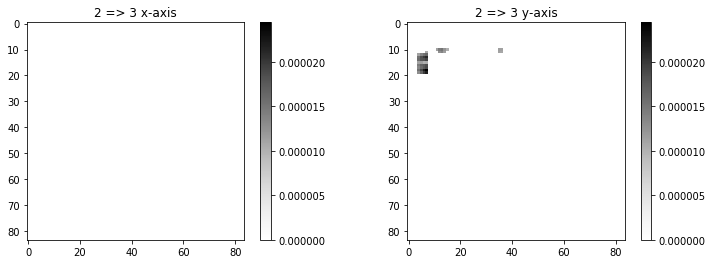

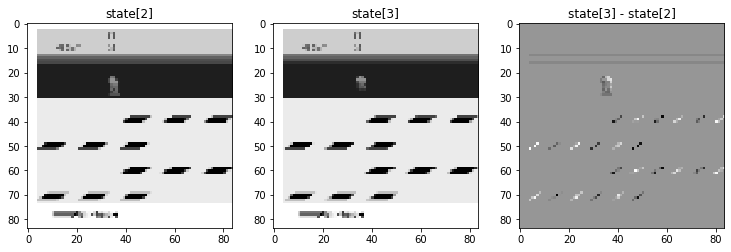

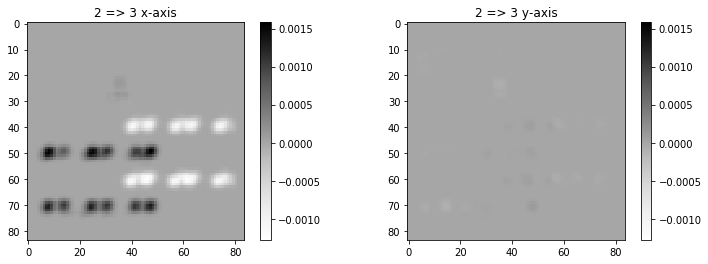

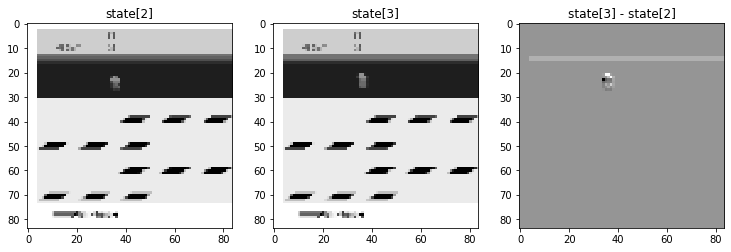

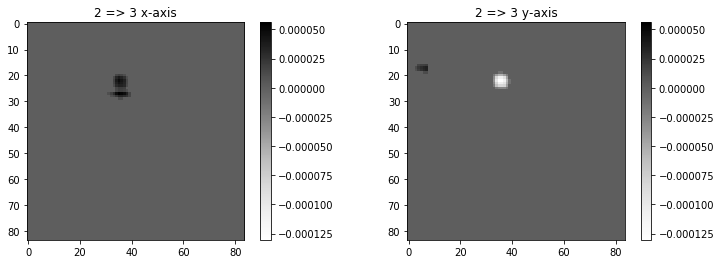

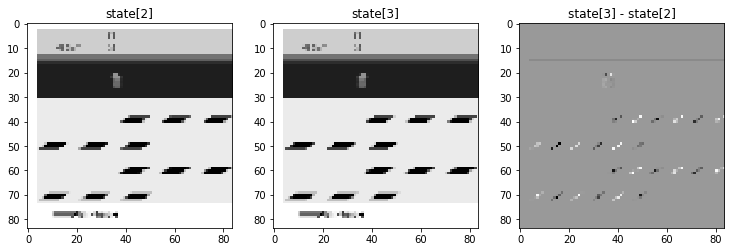

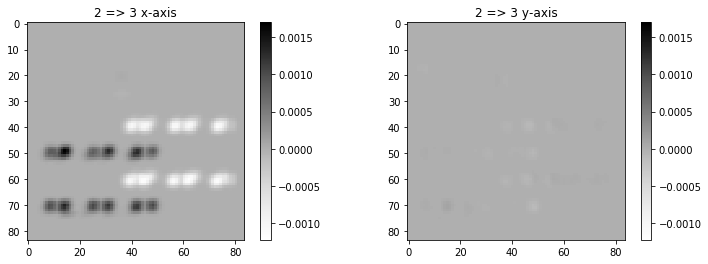

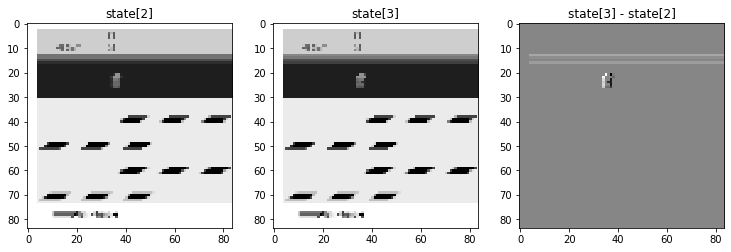

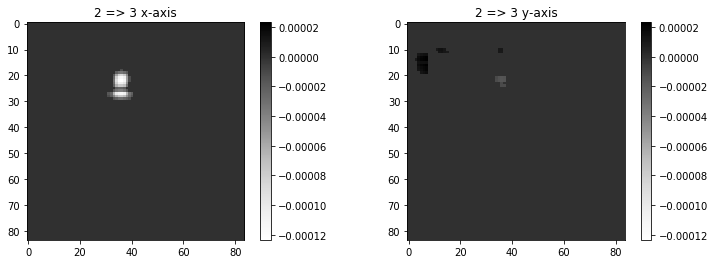

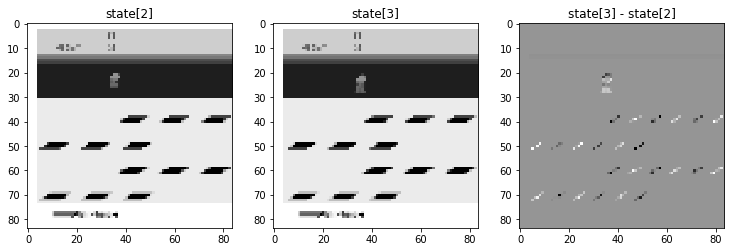

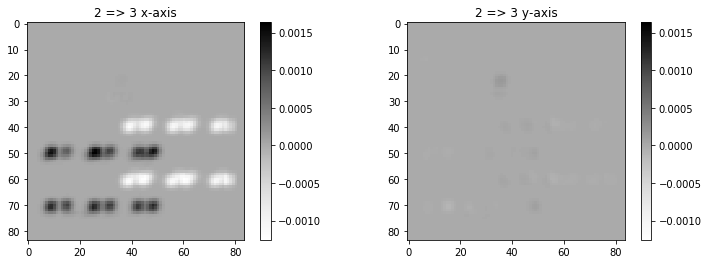

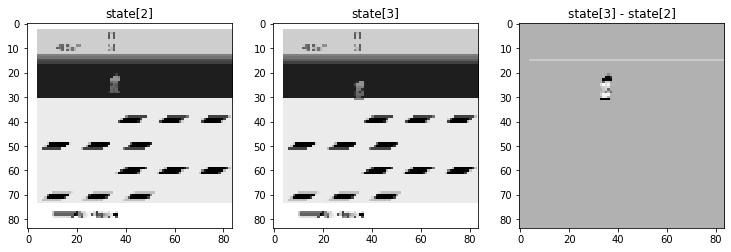

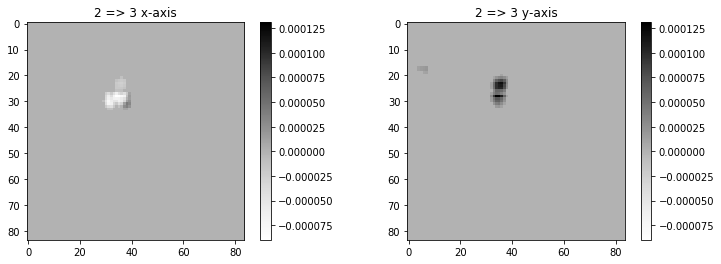

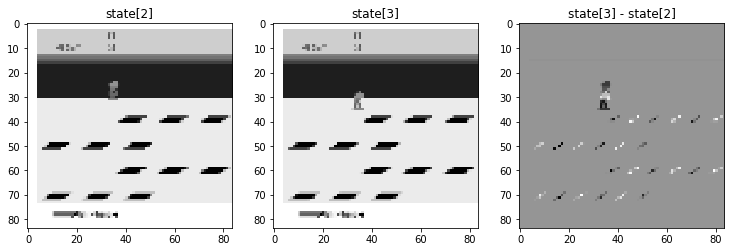

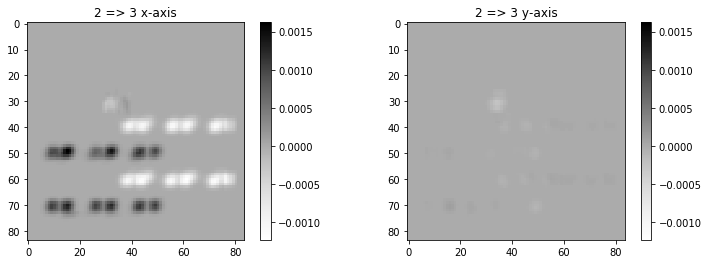

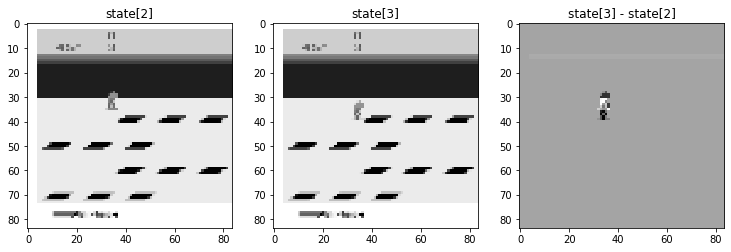

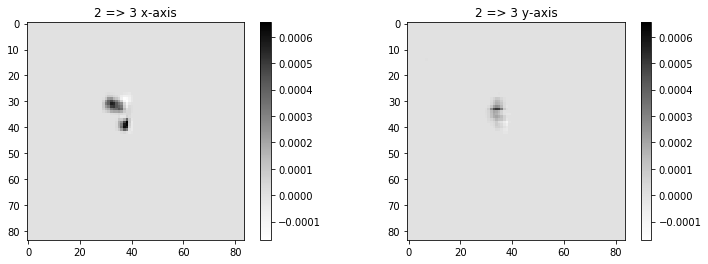

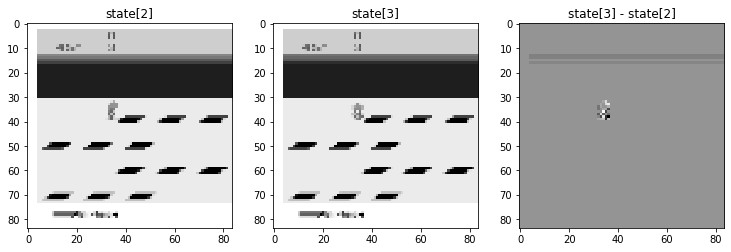

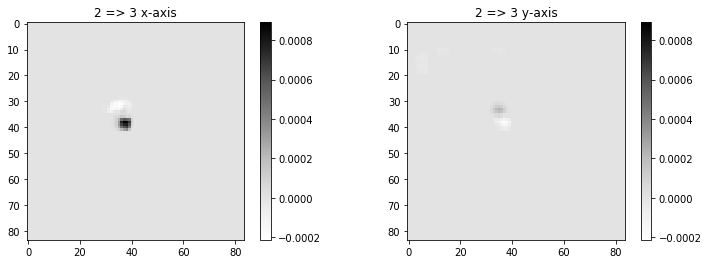

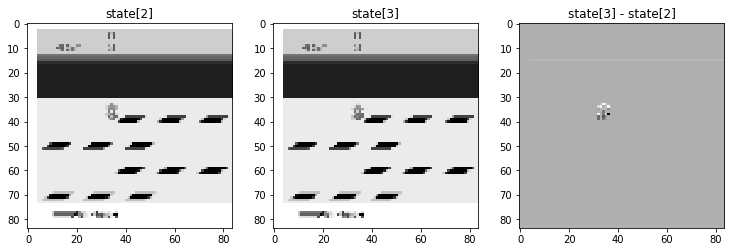

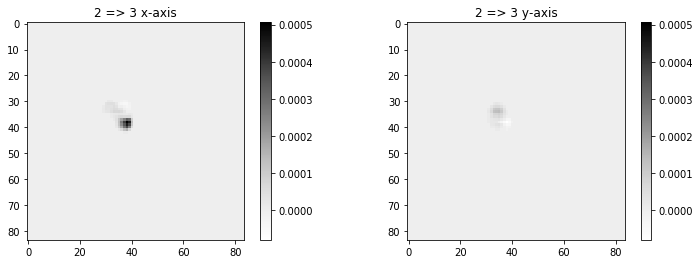

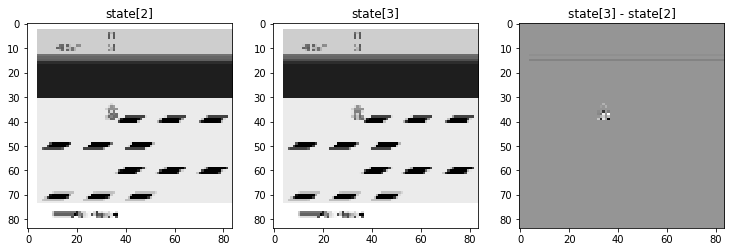

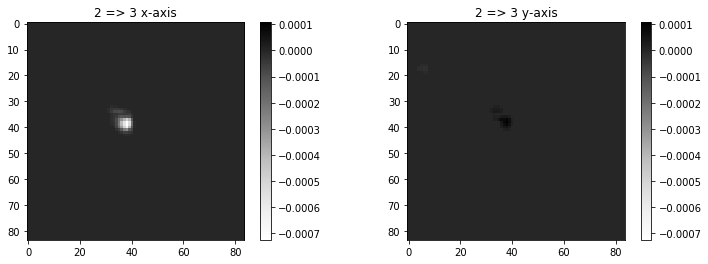

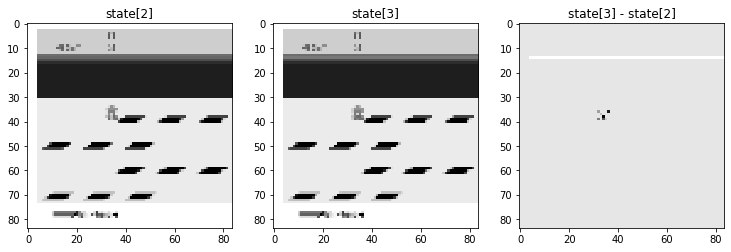

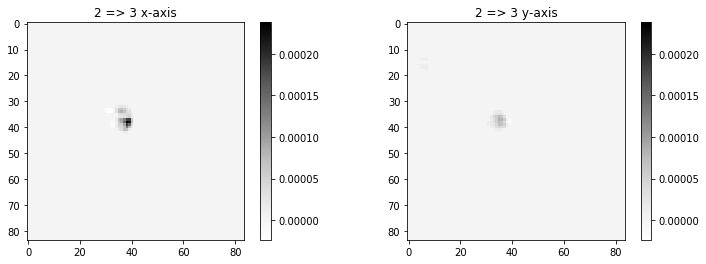

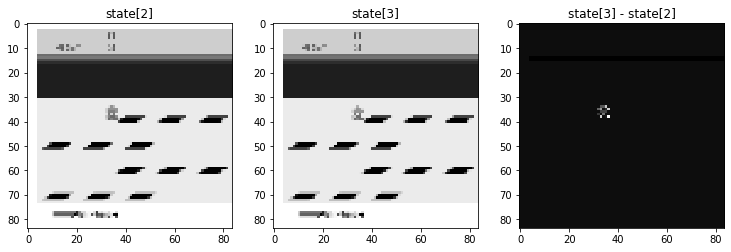

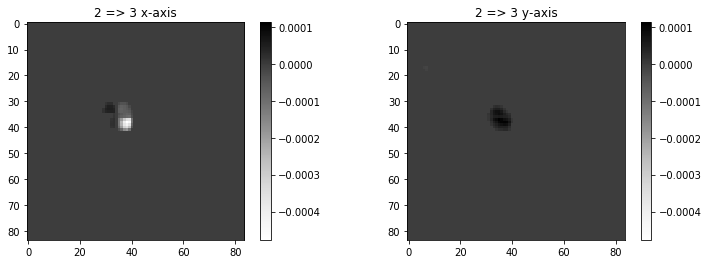

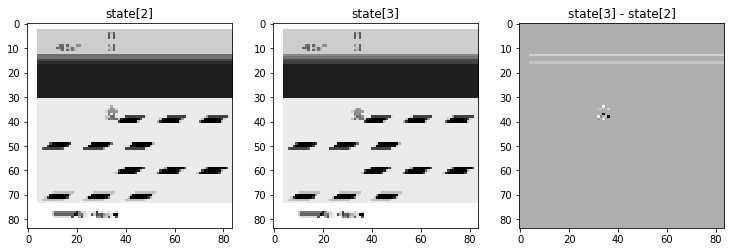

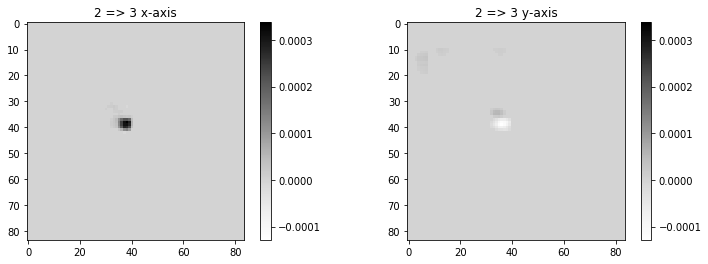

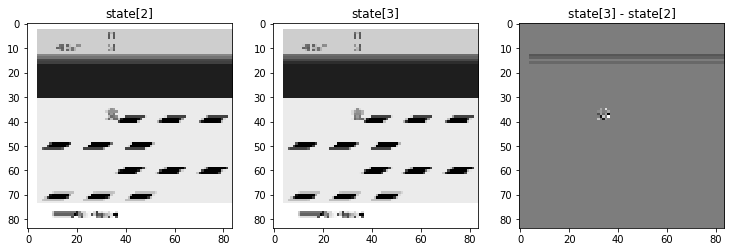

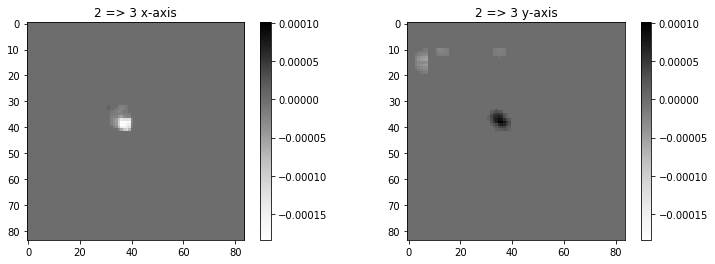

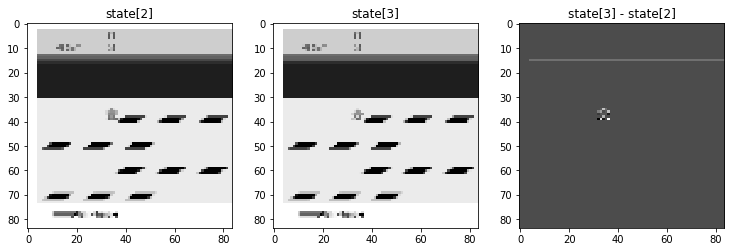

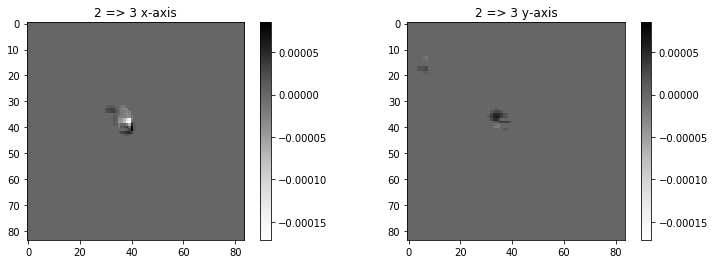

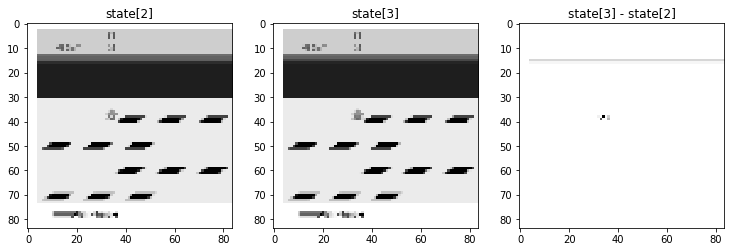

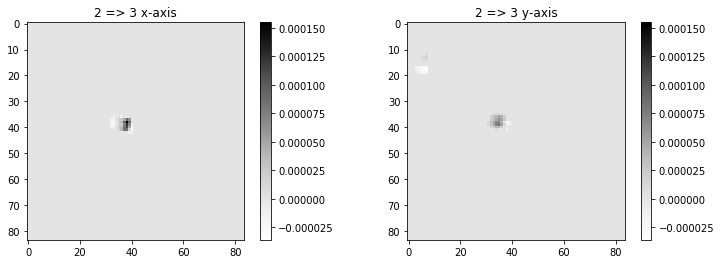

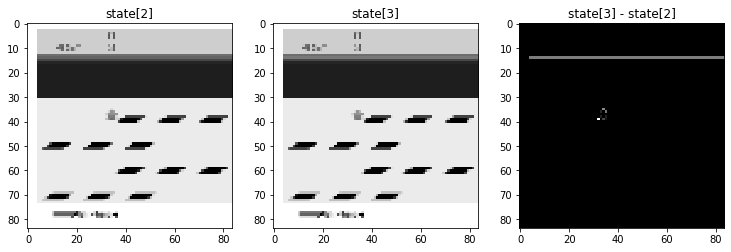

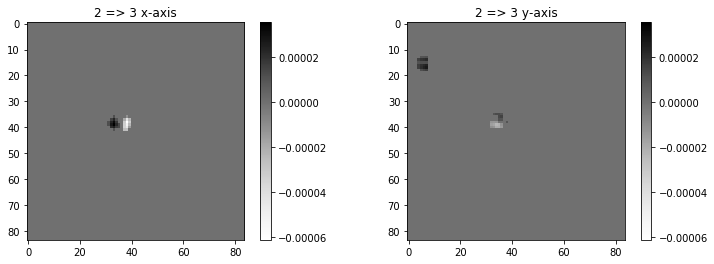

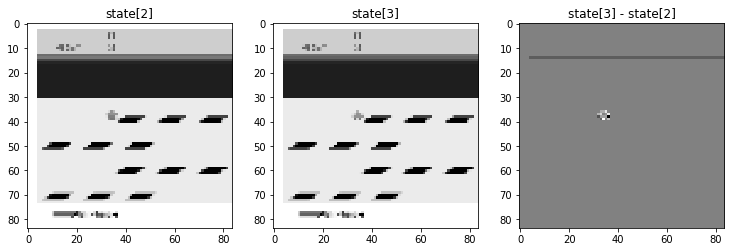

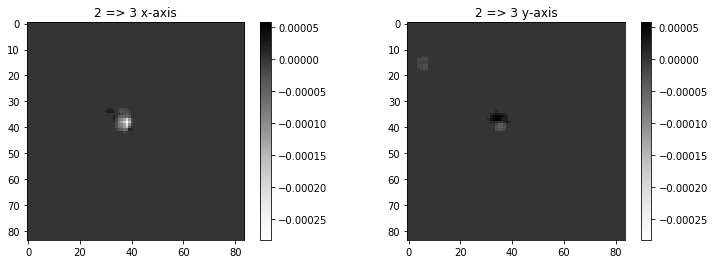

In [67]:
NROWS = 1
NCOLS = 3
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0

val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for _ in range(30):
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    if done:
        state, done = env.reset(), False

    np_state = state.cpu().numpy()
        
    for i in range(2, state.shape[0]):
        ax = plt.subplot(NROWS, NCOLS, i - 1)
        ax.imshow(np_state[i], cmap='Greys')
        ax.set_title(f'state[{i}]')
        
    # Plot subtraction between them
    ax = plt.subplot(NROWS, NCOLS, 3)
    ax.imshow(np_state[3] - np_state[2], cmap='Greys')
    ax.set_title(f'state[3] - state[2]')
    
    plt.show()
    
    """
    # For a quick comparison, to a state[2] => state[3] flow, and a state[0] => state[3] flow    
    flow_0_3 = cv2.calcOpticalFlowFarneback(np_state[0], np_state[3], None, **farneback_params)
    flow_2_3 = cv2.calcOpticalFlowFarneback(np_state[2], np_state[3], None, **farneback_params)
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    for i, (flow, name) in enumerate(zip((flow_0_3, flow_2_3), ('Flow 0 => 3', 'Flow 2 => 3'))):
        x_ax = plt.subplot(NROWS, NCOLS, 2 * i + 1)
        x_ax.imshow(flow[:,:,0], cmap='Greys')
        x_ax.set_title(f'{name} x-axis')
        
        y_ax = plt.subplot(NROWS, NCOLS, 2 * i + 2)
        y_ax.imshow(flow[:,:,1], cmap='Greys')
        y_ax.set_title(f'{name} y-axis')
    """
    flow_2_3 = cv2.calcOpticalFlowFarneback(np_state[2], np_state[3], None, **farneback_params)
    flow_2_3[np.abs(flow_2_3) < FLOW_TOLERANCE] = 0
    normalizer = matplotlib.colors.Normalize(np.min(flow_2_3), np.max(flow_2_3))
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    x_ax = plt.subplot(1, 2, 1)
    x_res = x_ax.imshow(flow_2_3[:,:,0], cmap='Greys', norm=normalizer)
    figure.colorbar(x_res, ax=x_ax)
    x_ax.set_title(f'2 => 3 x-axis')

    y_ax = plt.subplot(1, 2, 2)
    y_res = y_ax.imshow(flow_2_3[:,:,1], cmap='Greys', norm=normalizer)
    figure.colorbar(y_res, ax=y_ax)
    y_ax.set_title(f'2 => 3 y-axis')
    
    plt.show()
    
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

### Use random frame samples to test out background subtraction

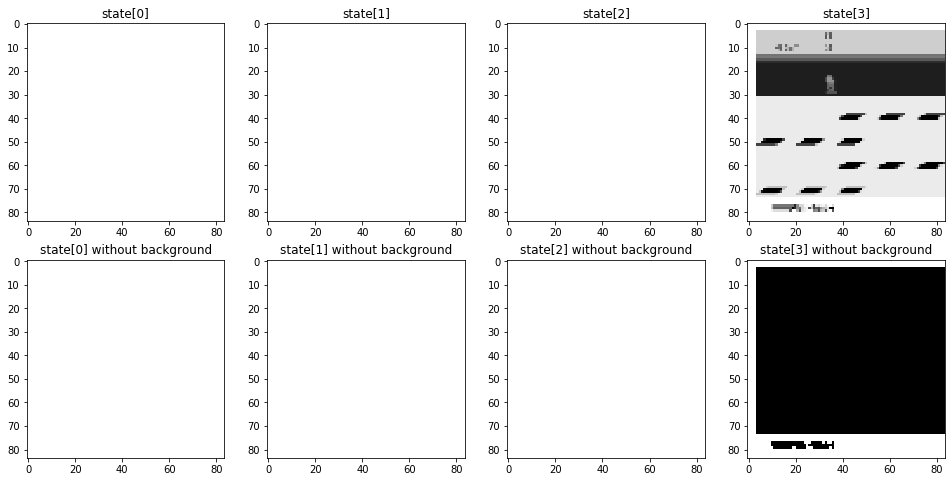

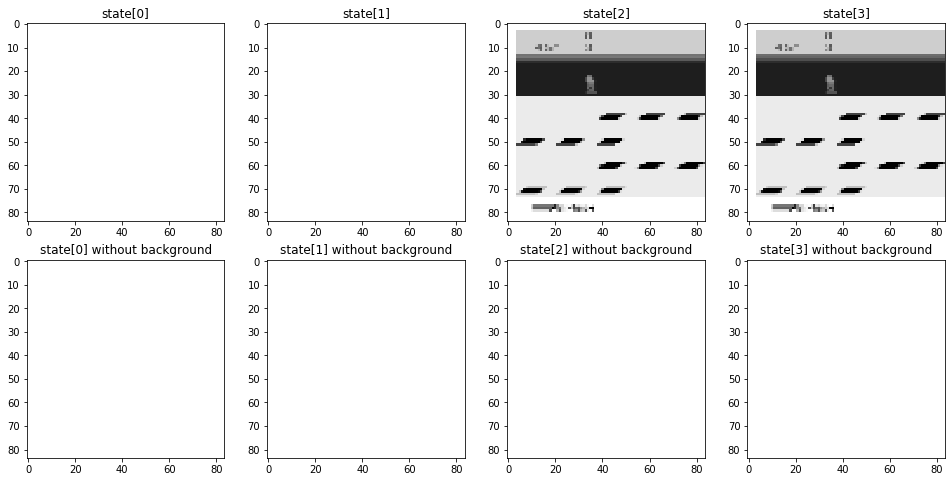

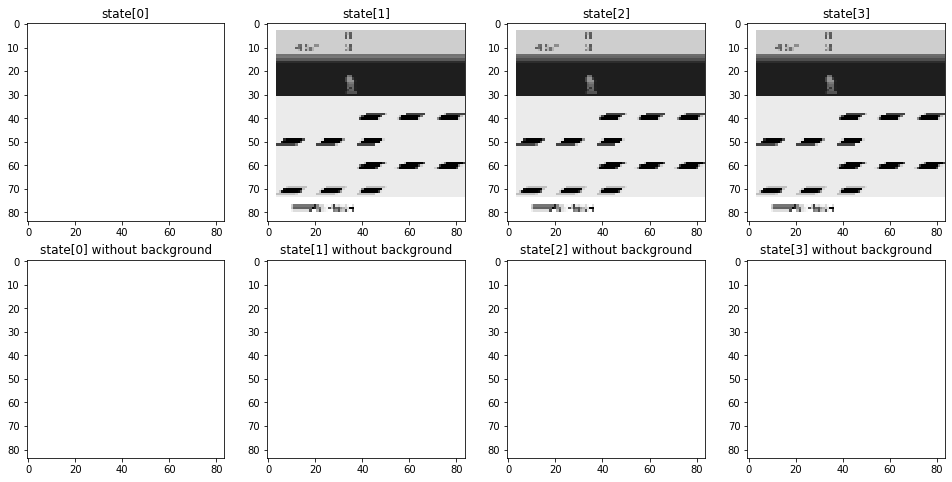

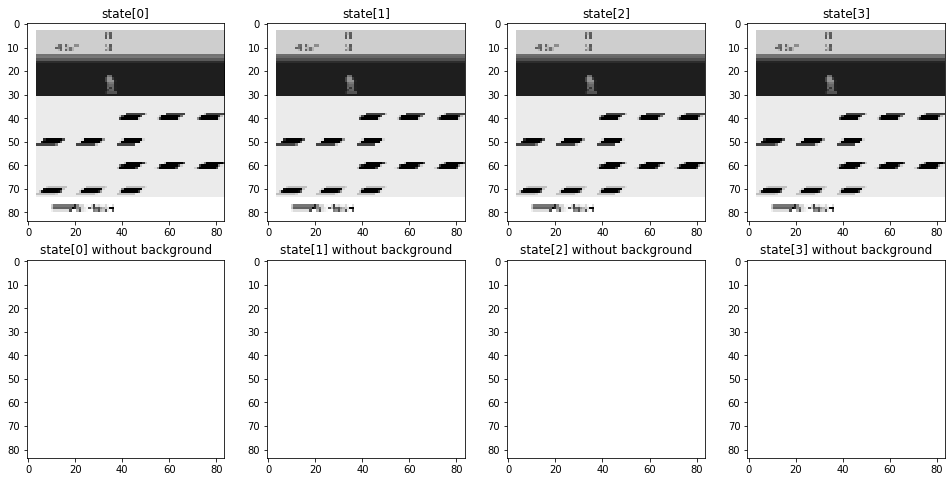

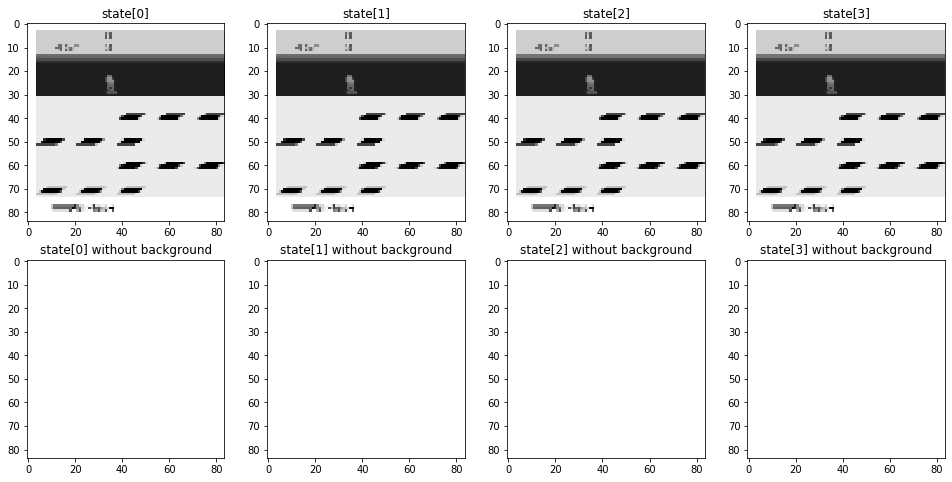

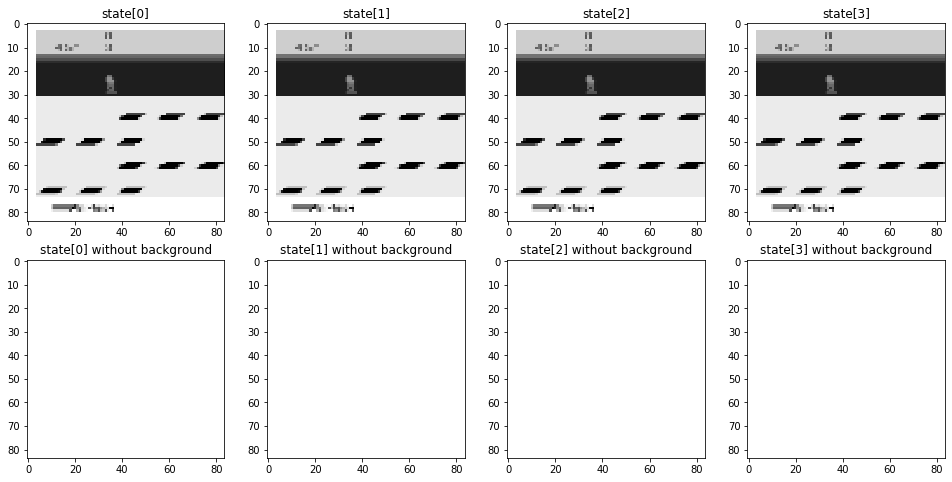

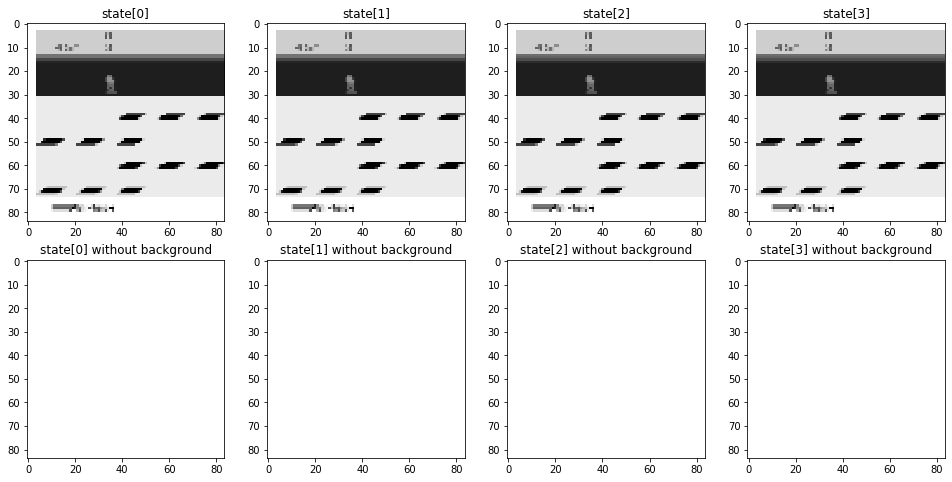

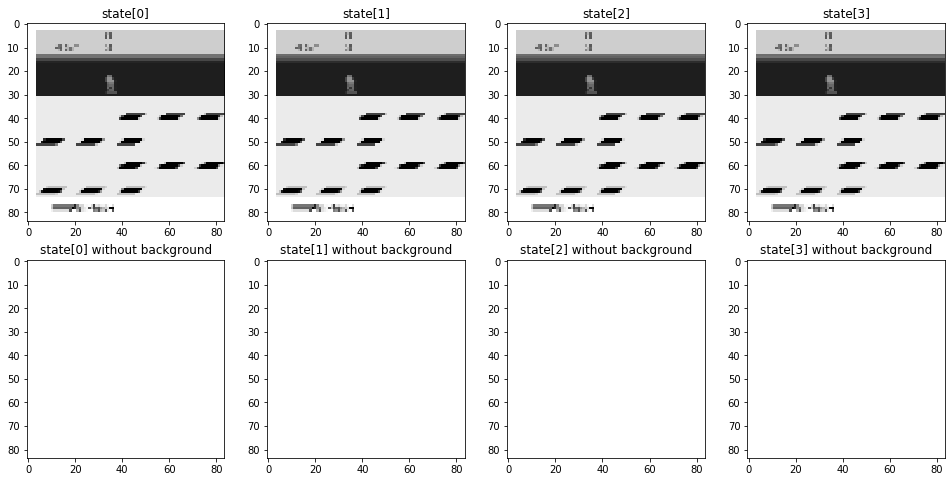

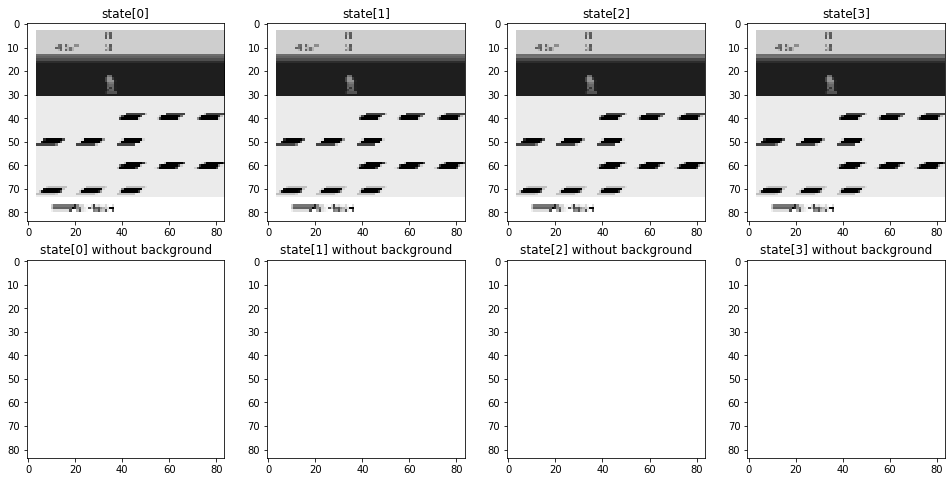

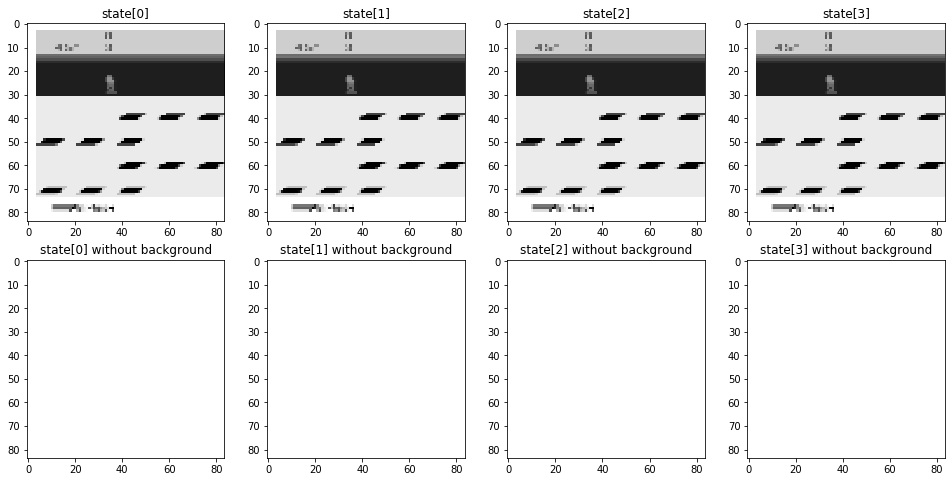

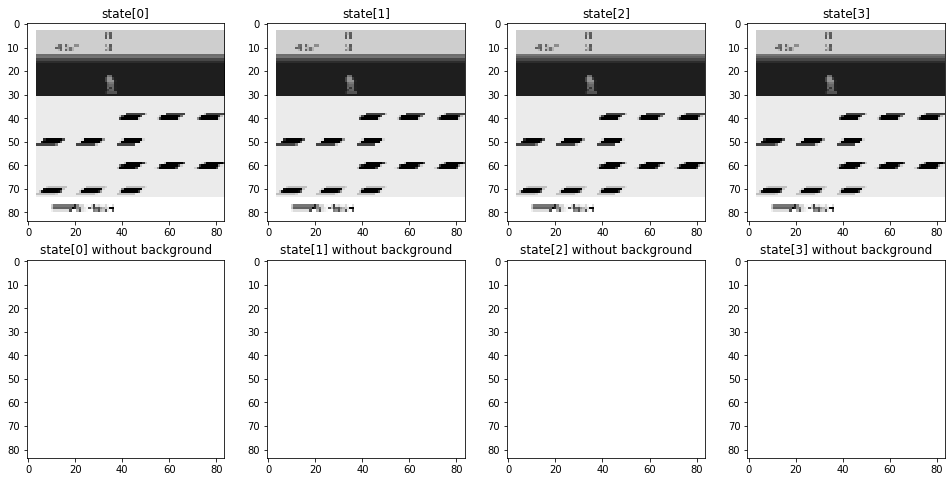

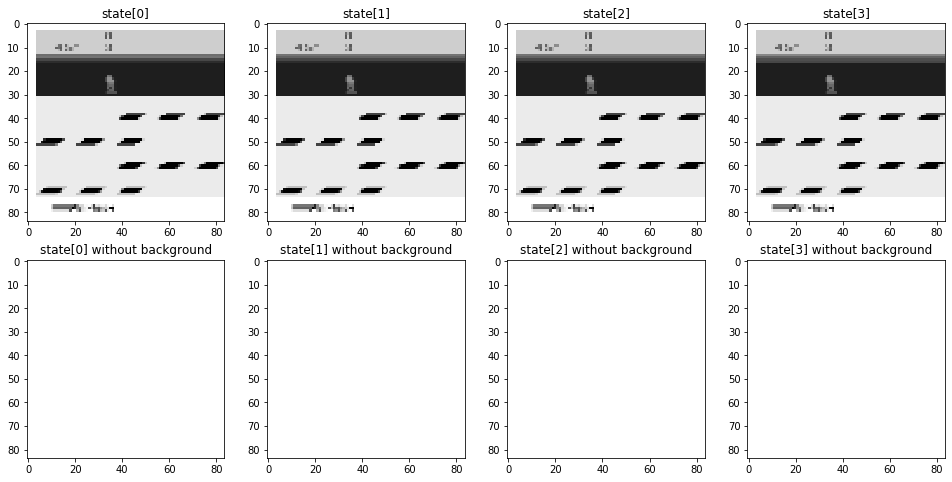

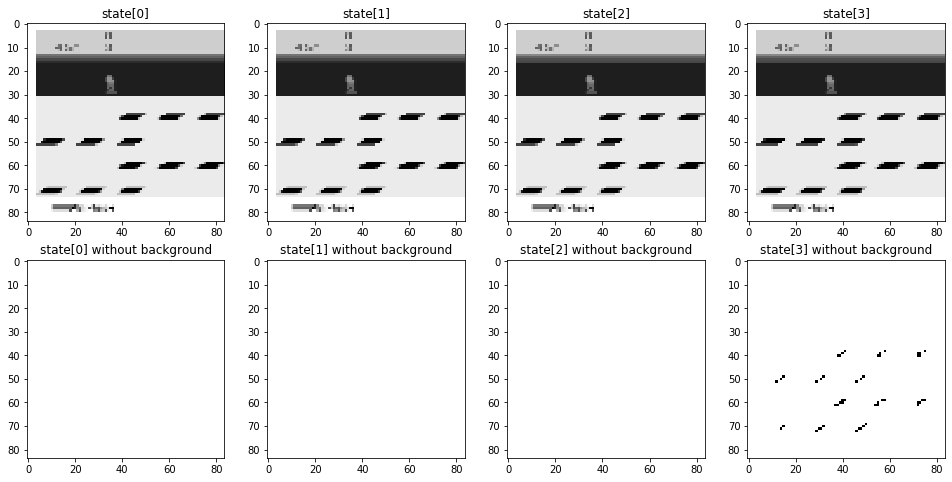

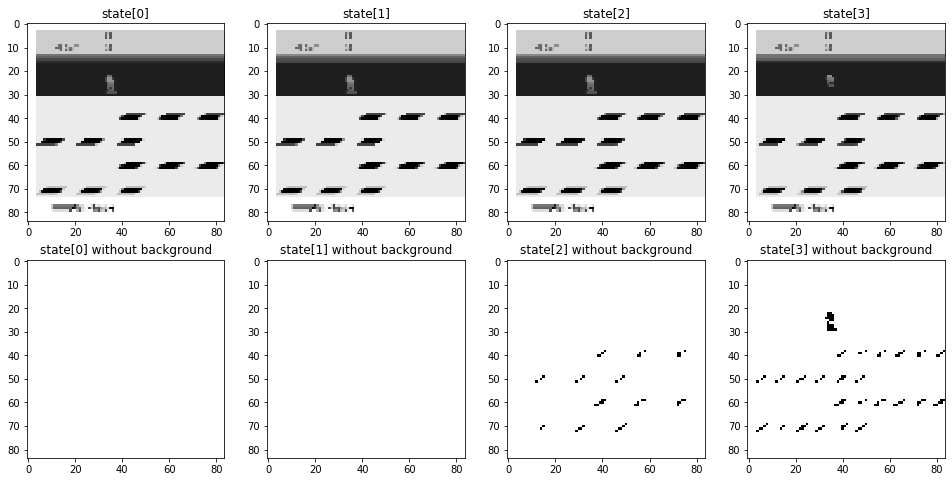

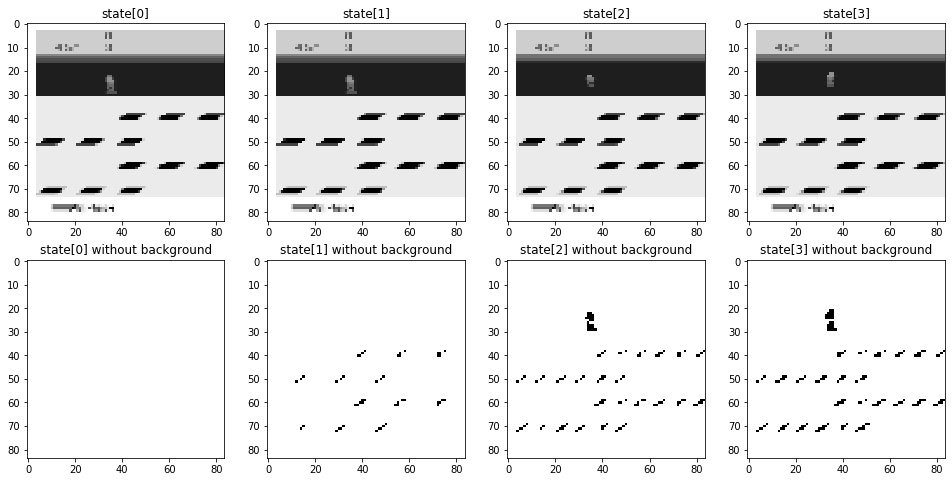

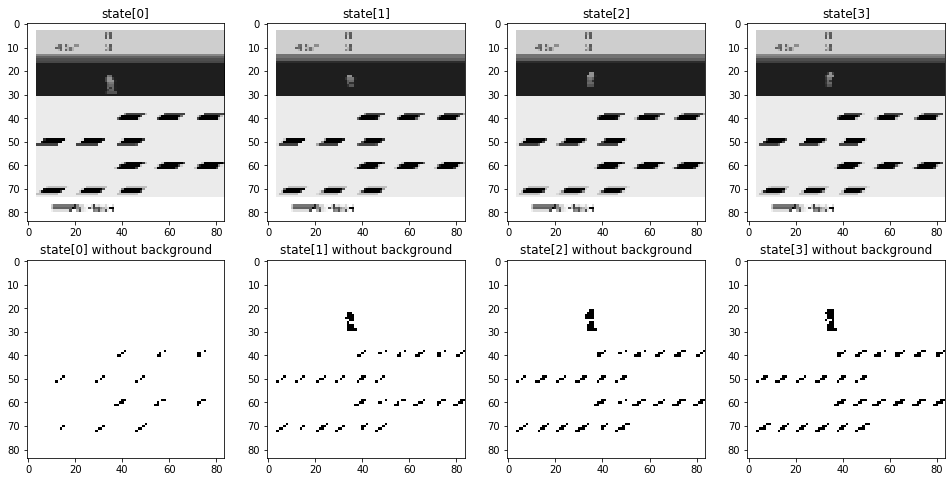

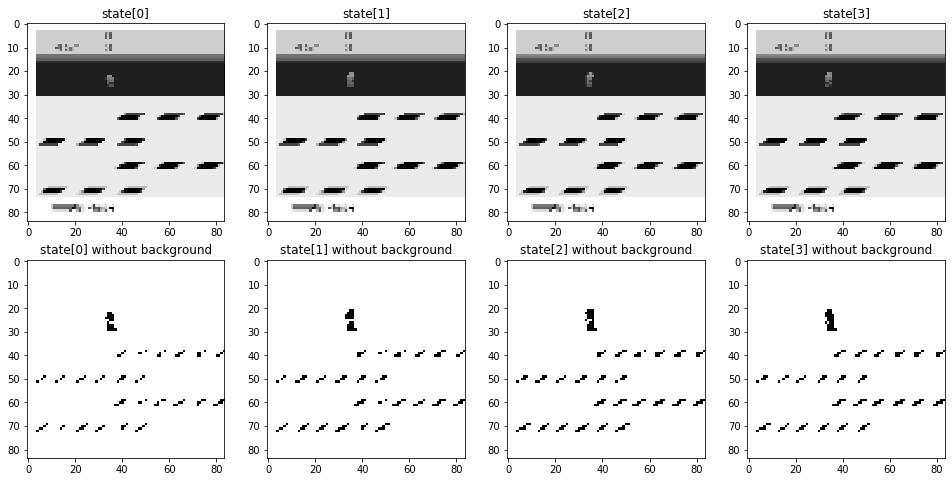

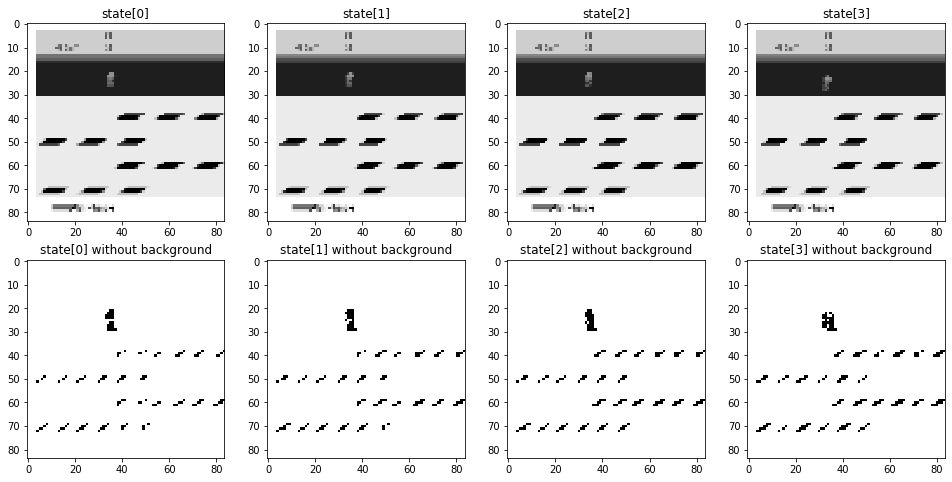

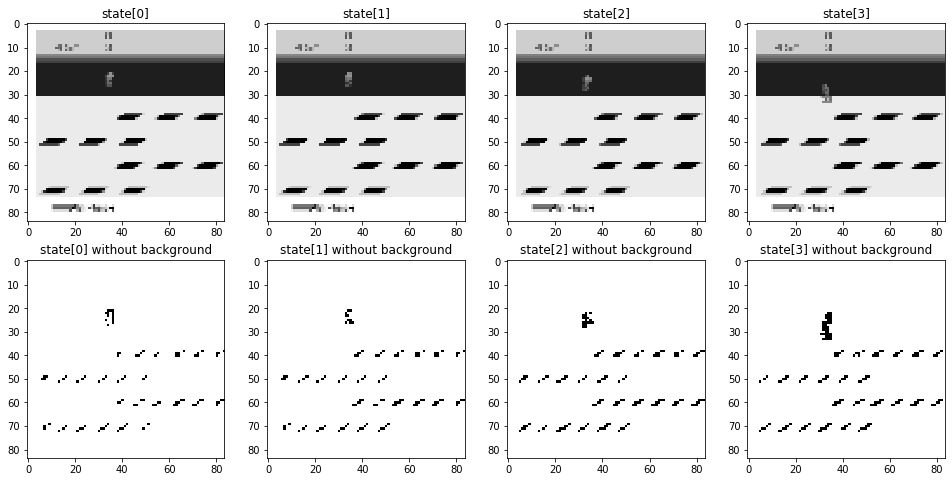

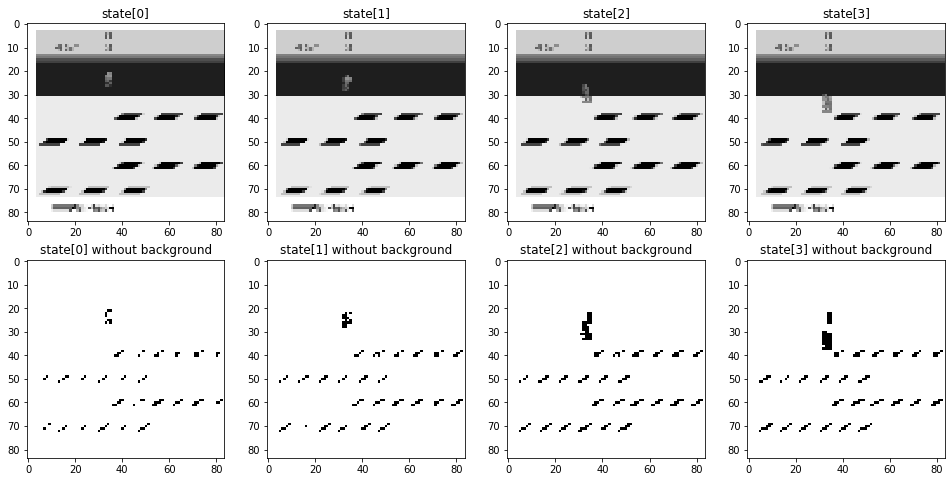

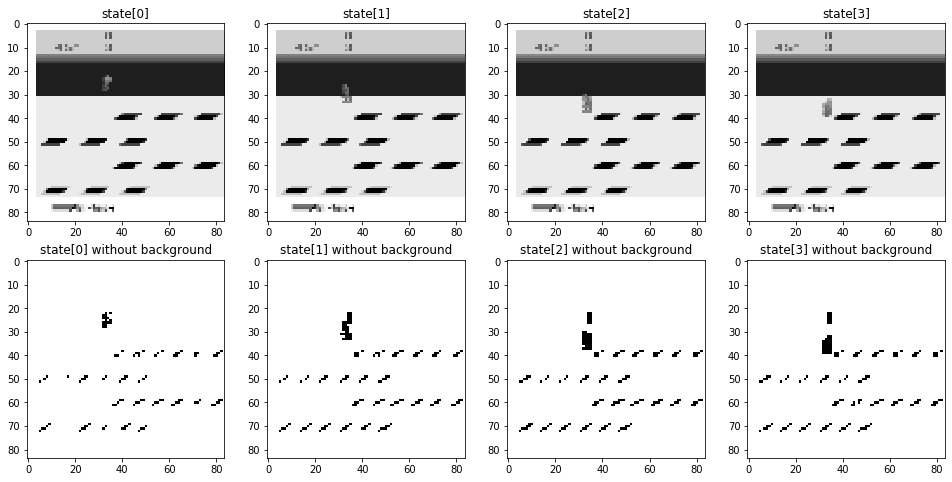

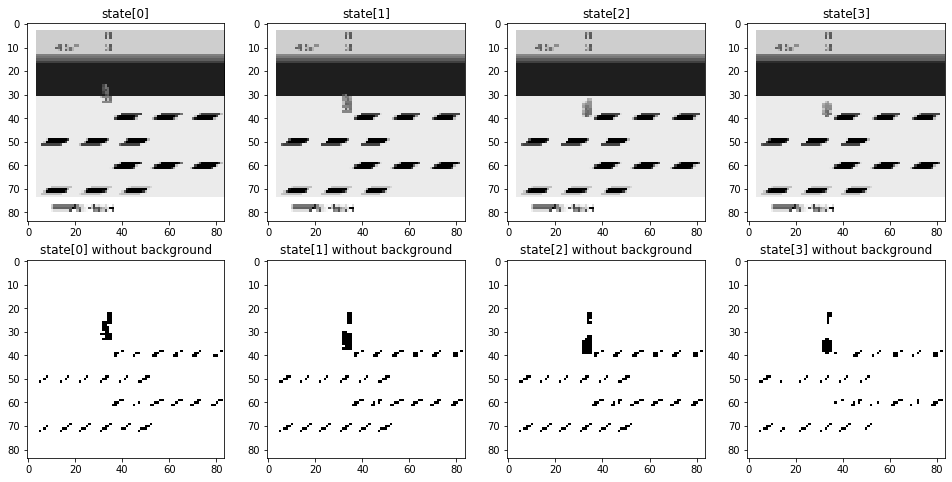

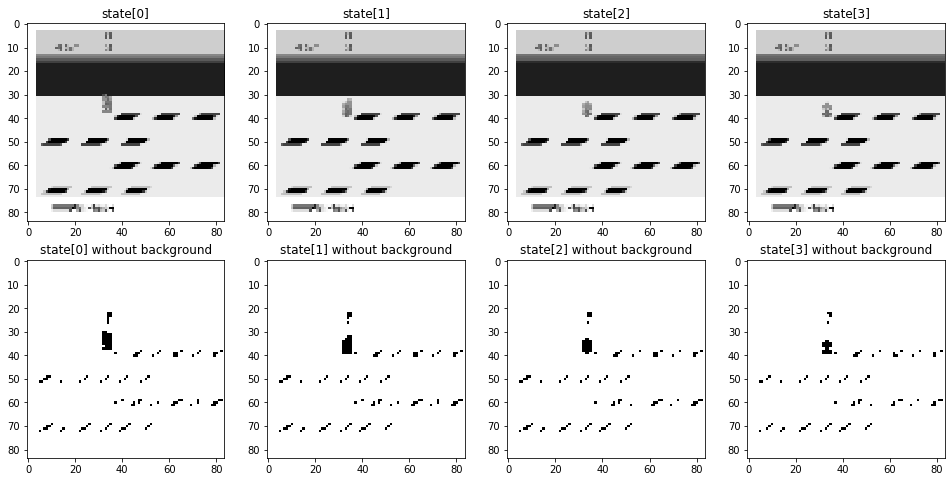

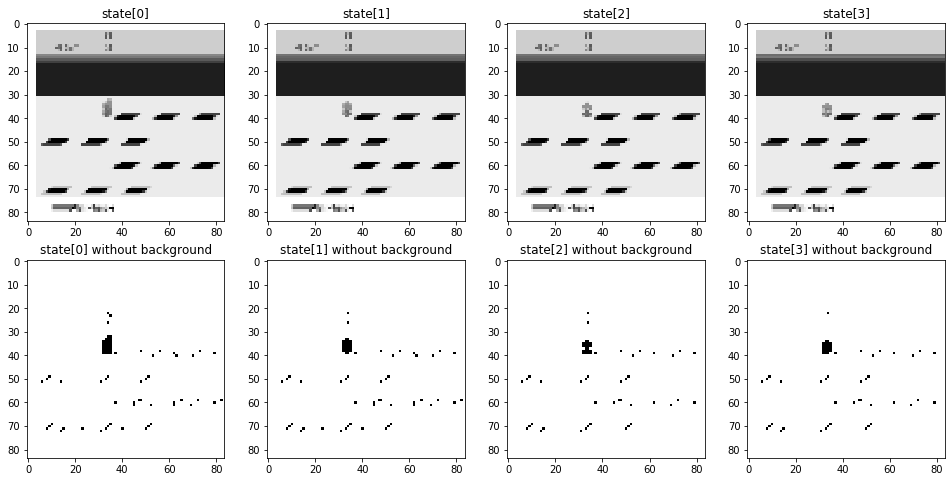

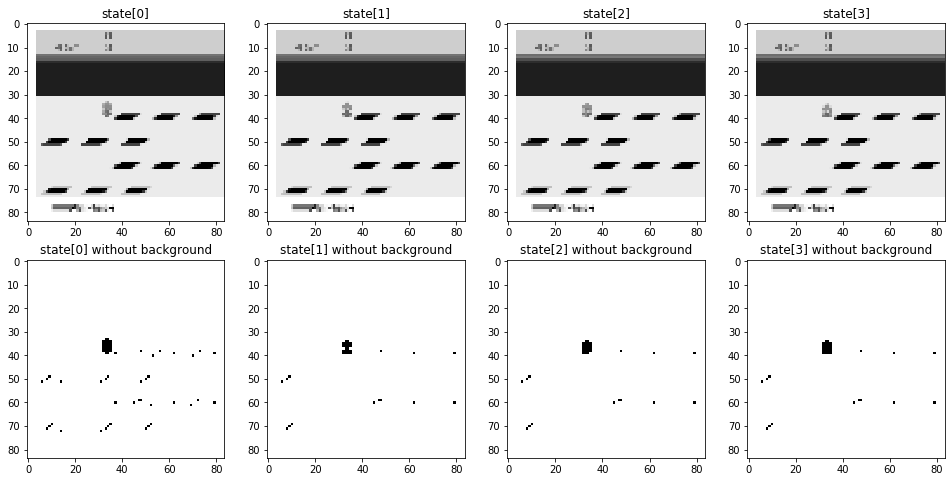

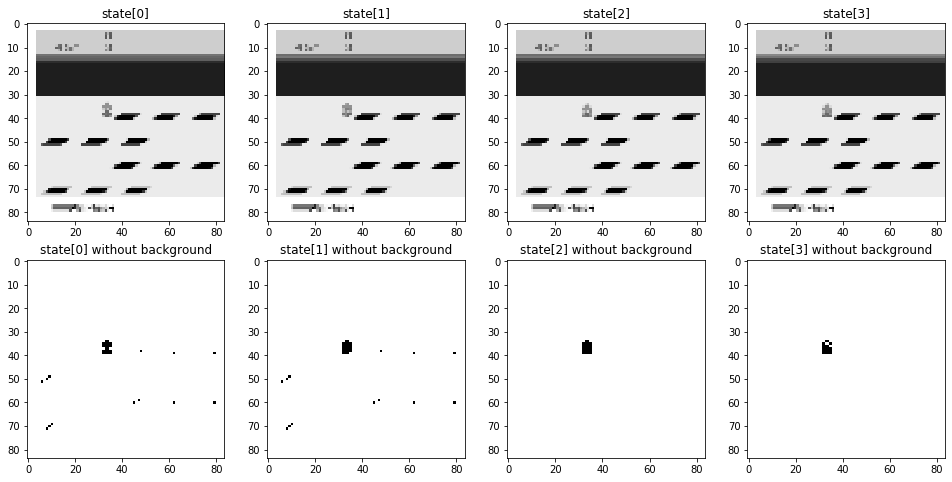

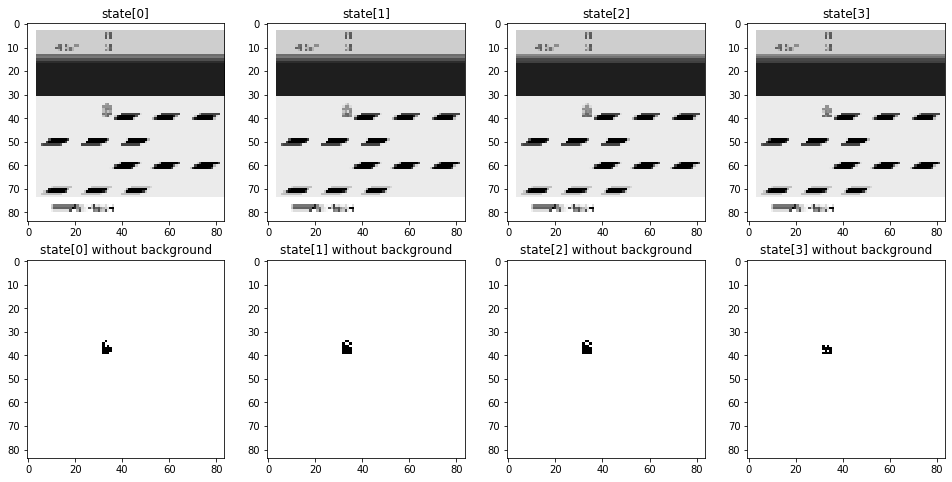

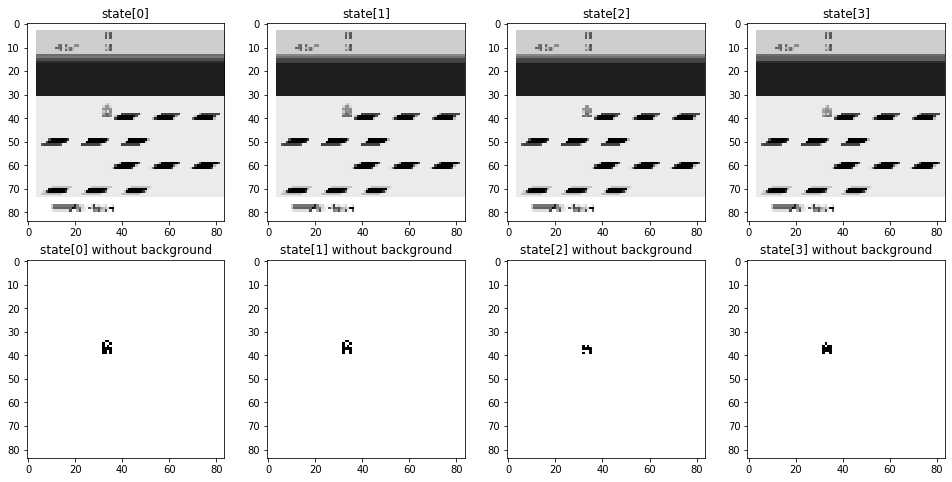

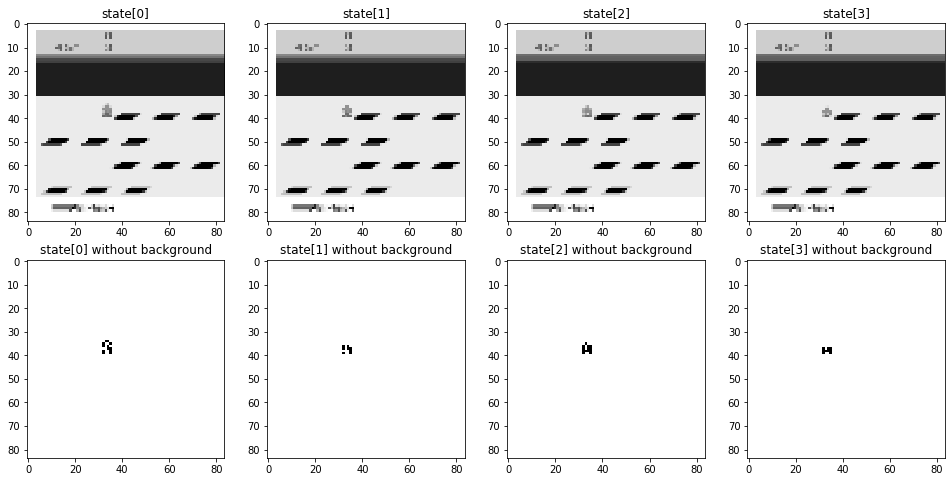

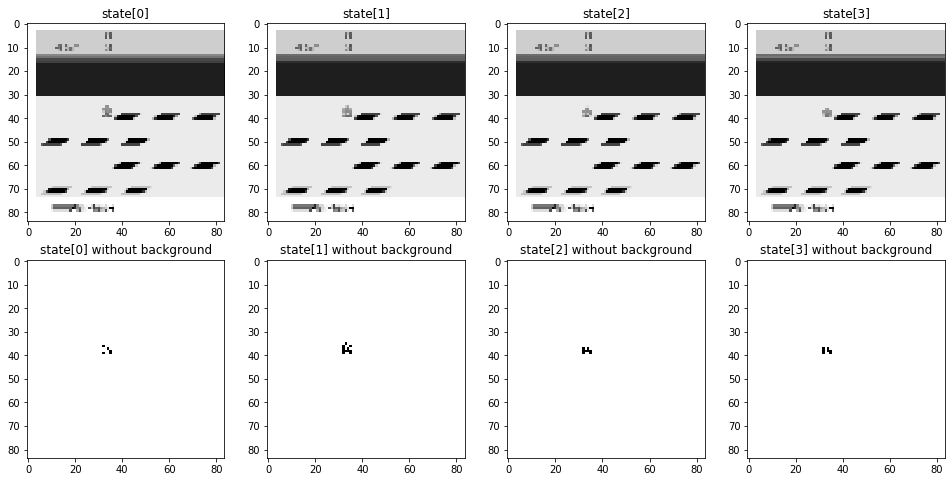

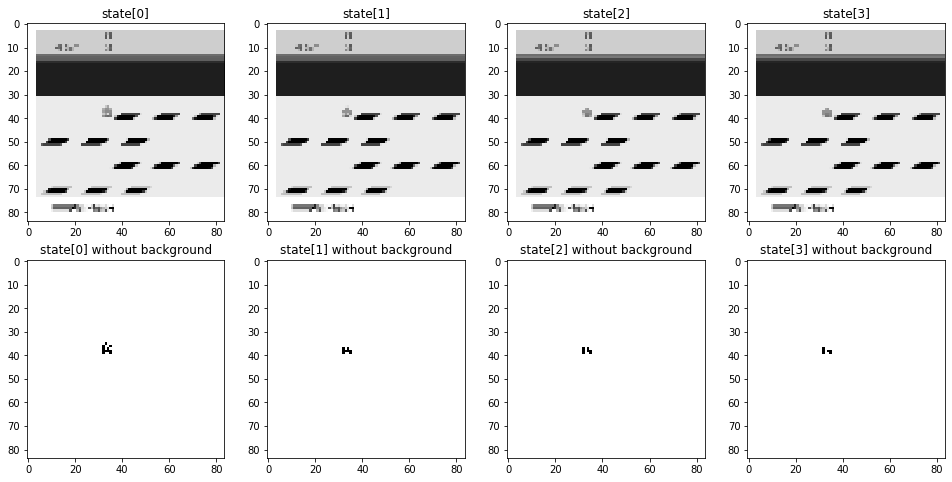

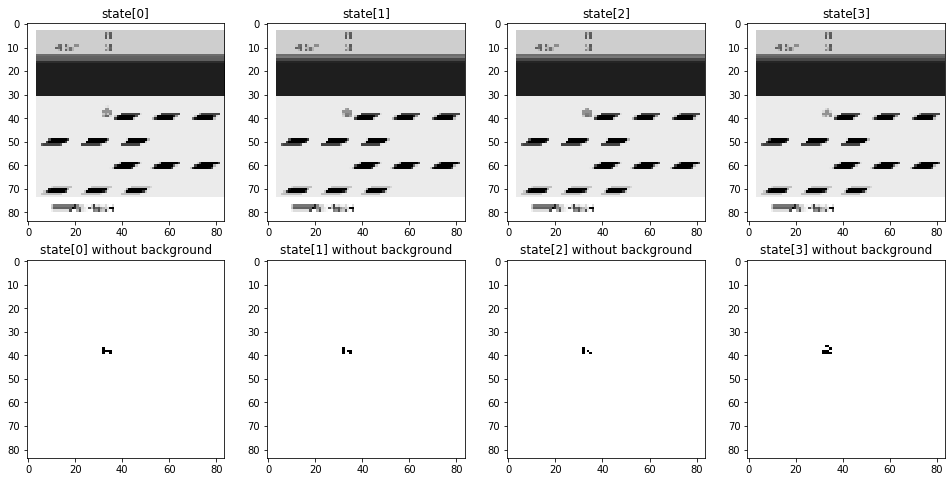

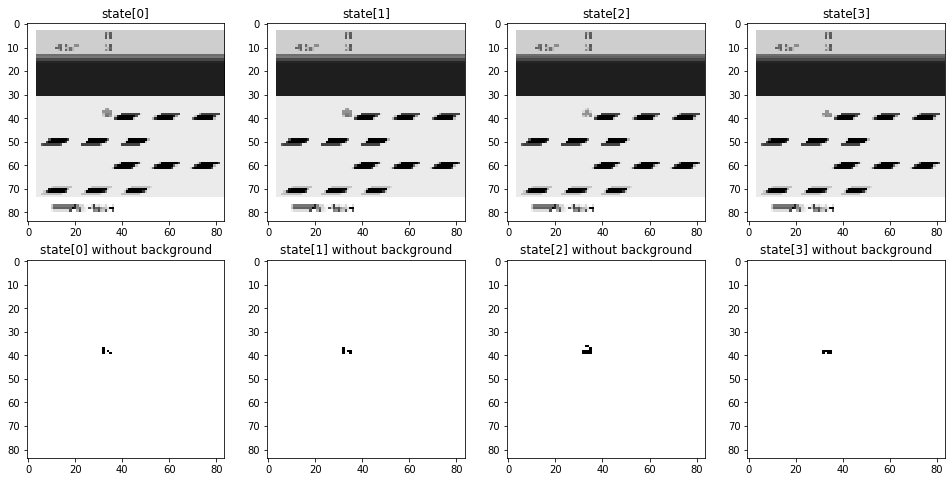

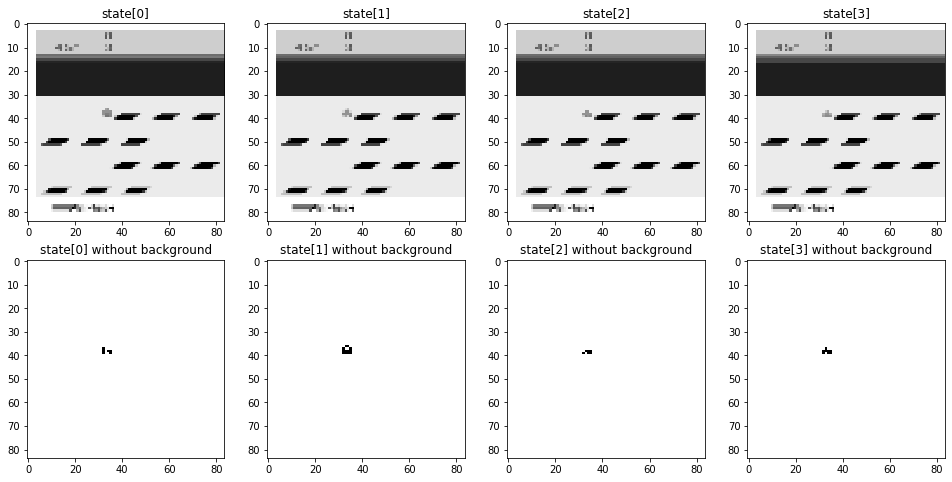

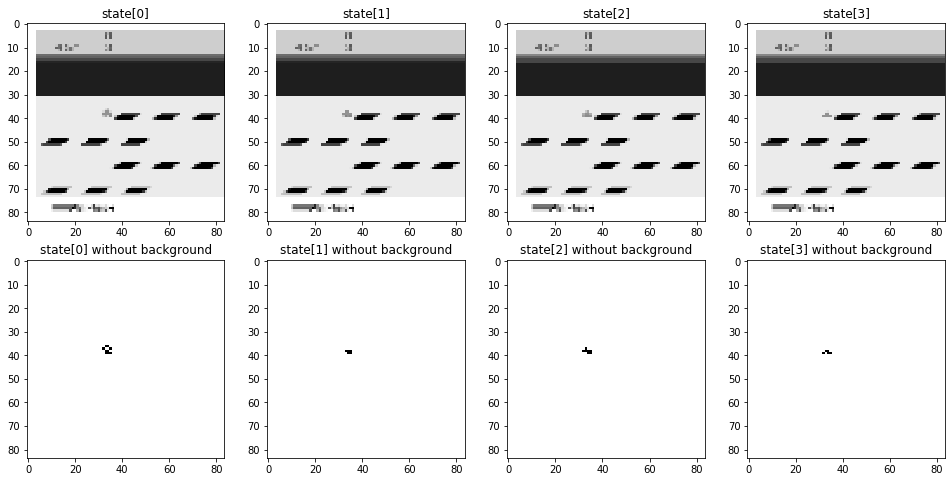

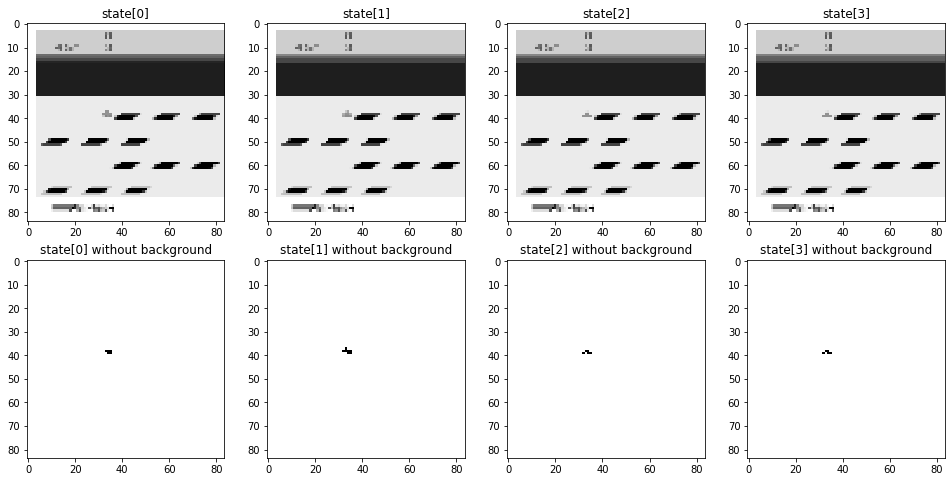

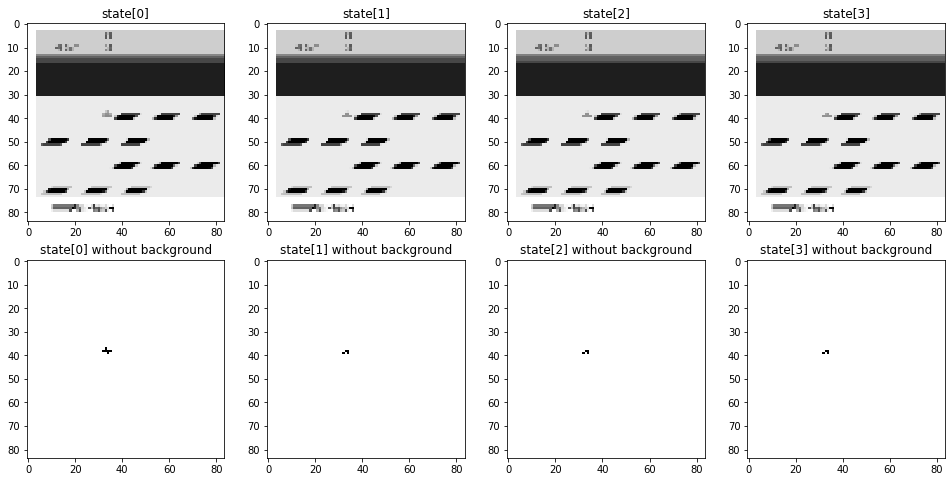

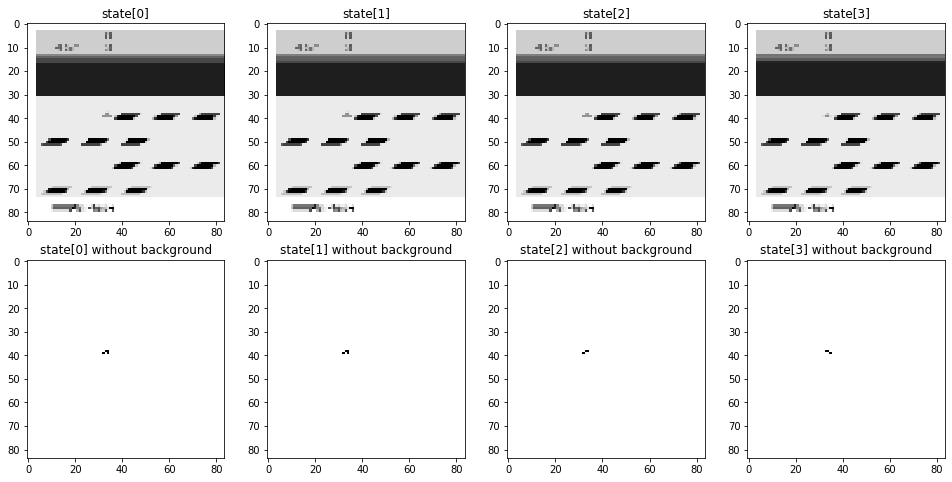

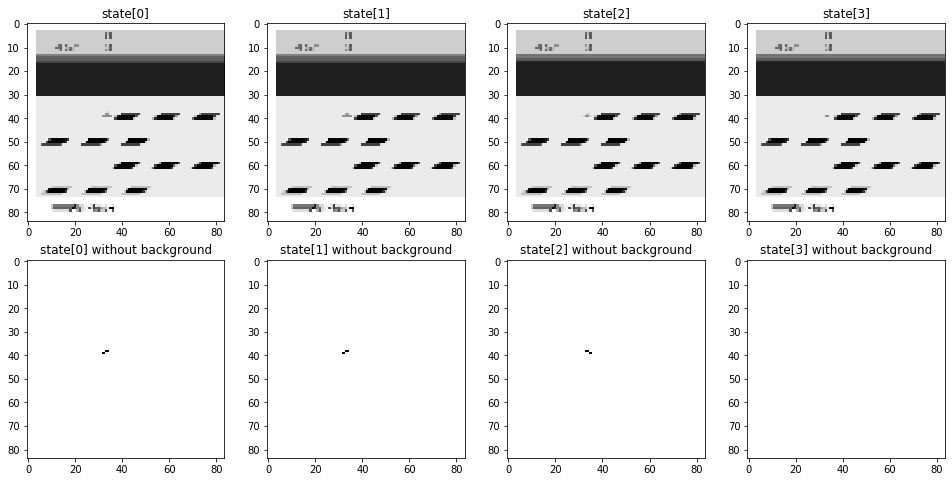

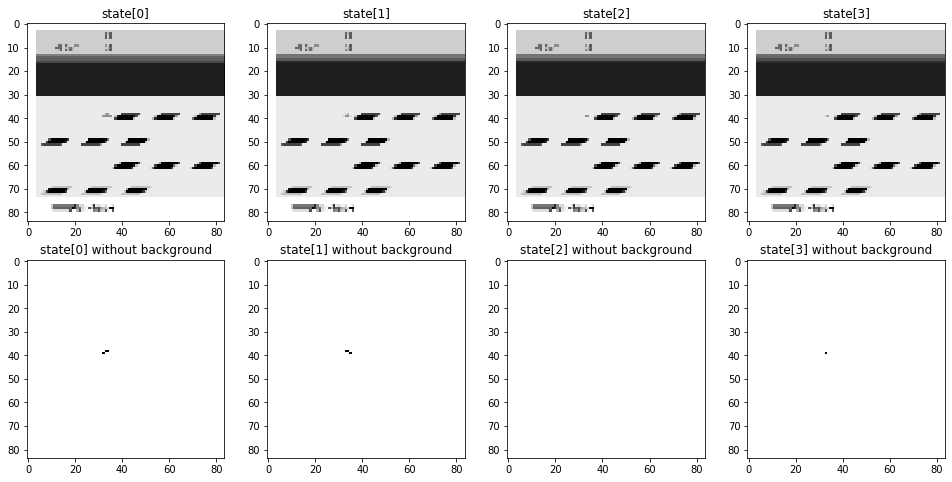

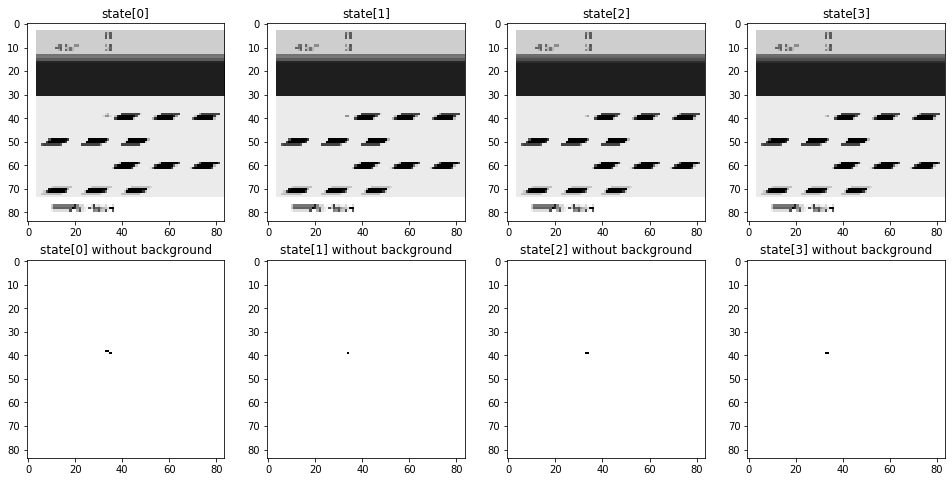

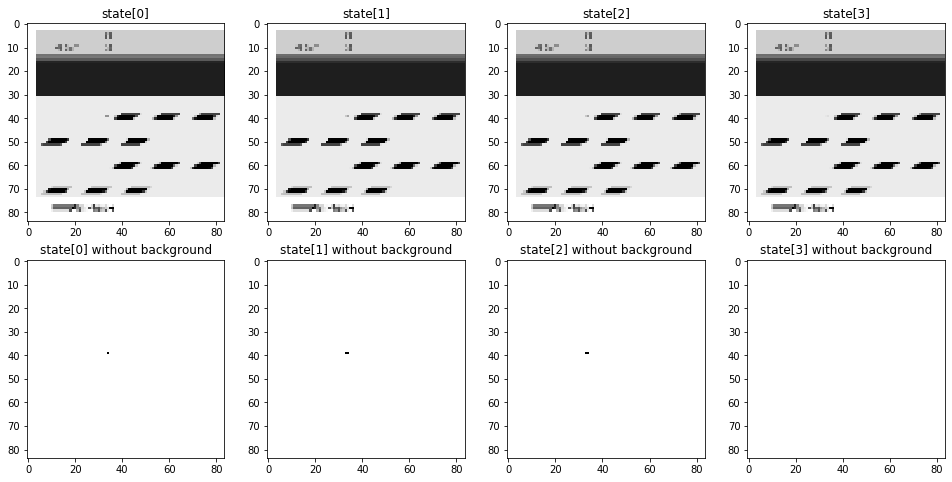

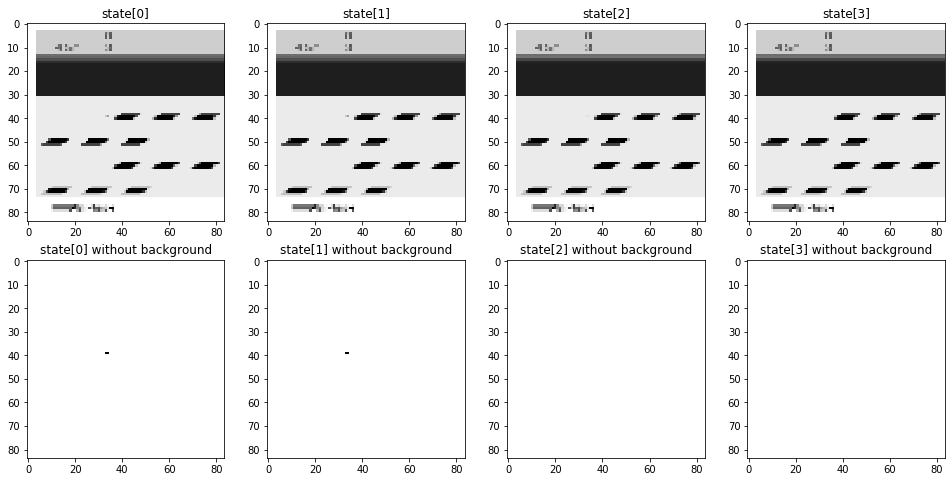

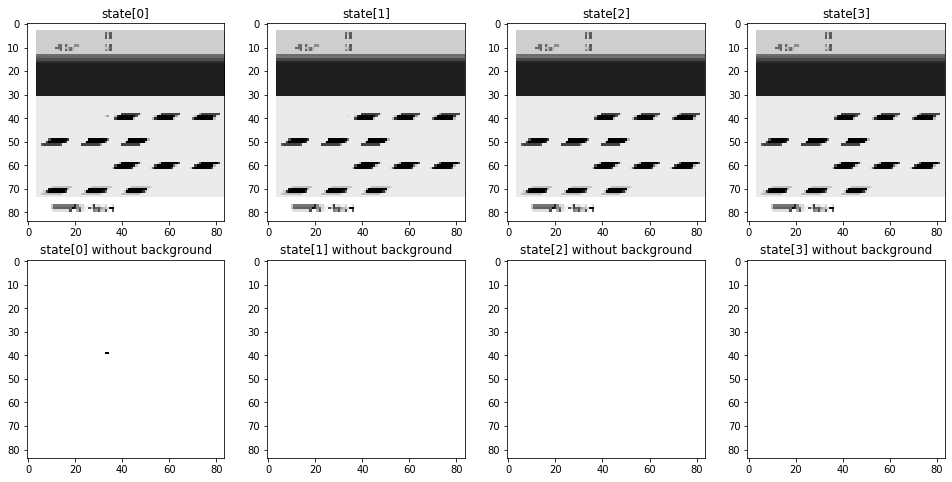

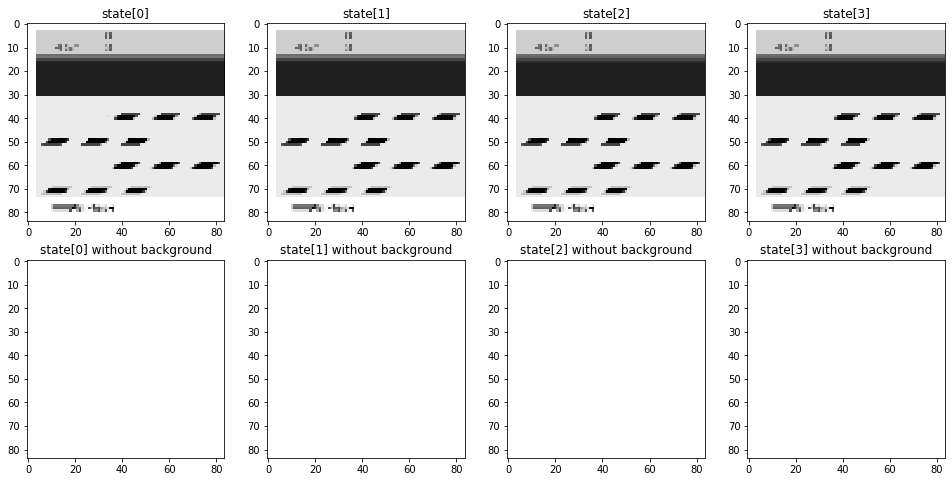

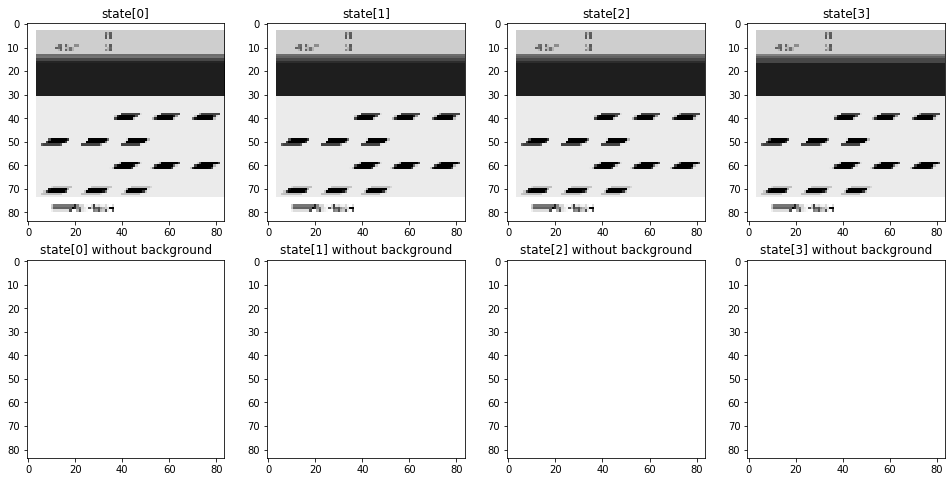

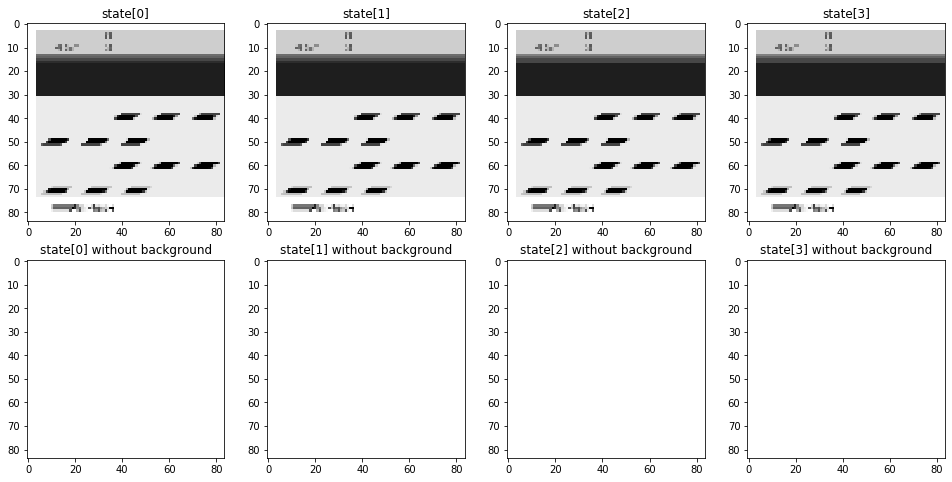

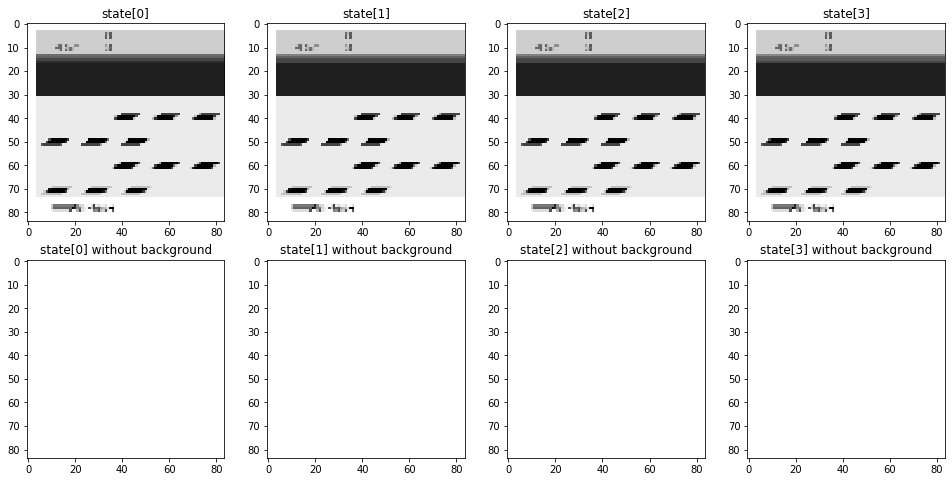

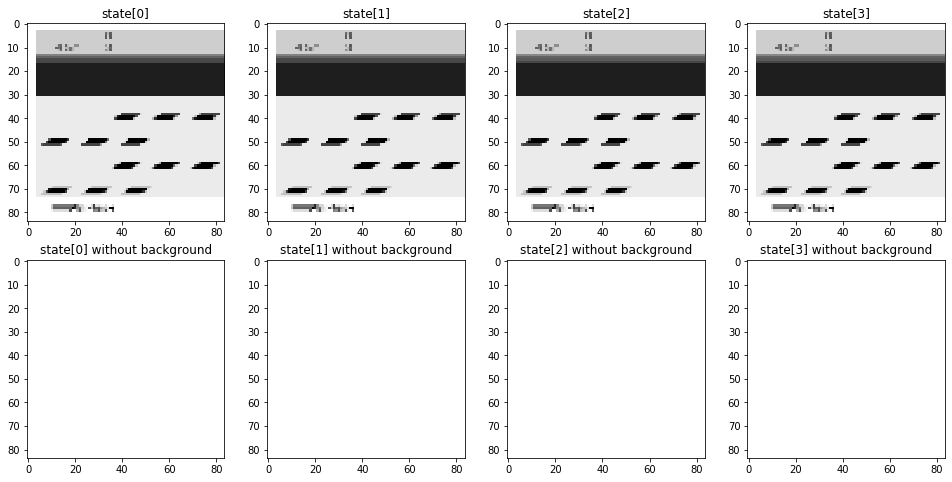

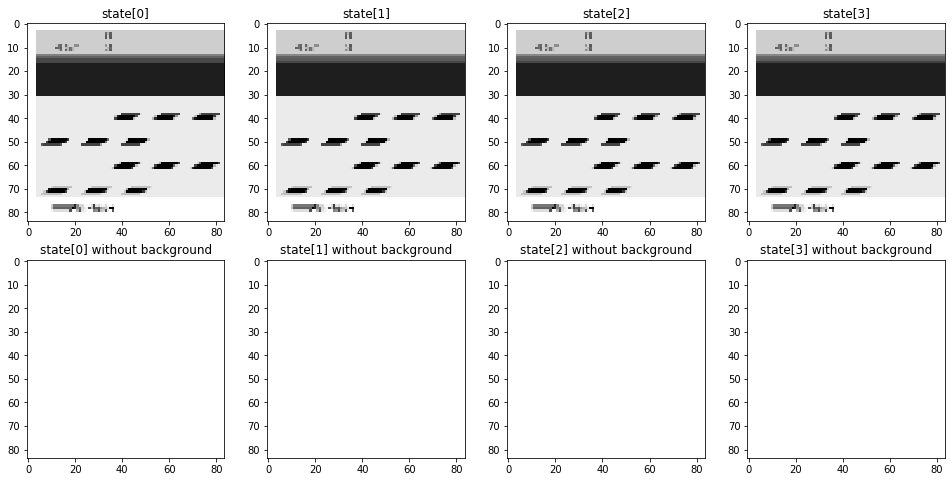

In [79]:
NROWS = 2
NCOLS = 4
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0

# First, let the background subtractor get some 100 random images
background_sub = cv2.createBackgroundSubtractorMOG2(varThreshold=64, detectShadows=False)

# done = True
# for _ in range(100):
#     if done:
#         state, done = env.reset(), False

#     next_state, _, done = env.step(np.random.randint(0, action_space))
#     val_mem.append(state, None, None, done)
#     state = next_state

#     np_state = state.cpu().numpy()
#     for i in range(np_state.shape[0]): 
#         background_sub.apply(np_state[i] * 255)


# Now trying to actually use it
        
val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for _ in range(50):
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    if done:
        state, done = env.reset(), False

    np_state = state.cpu().numpy()
        
    for i in range(np_state.shape[0]):
        ax = plt.subplot(NROWS, NCOLS, i + 1)
        ax.imshow(np_state[i], cmap='Greys')
        ax.set_title(f'state[{i}]')
        
        background_subtracted = background_sub.apply(np_state[i] * 255)
        back_ax = plt.subplot(NROWS, NCOLS, i + 5)
        back_ax.imshow(background_subtracted, cmap='Greys')
        back_ax.set_title(f'state[{i}] without background')
        
    plt.show()
    
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

## Checking some things with my saved memory files

In [14]:
import time

mem_folder = os.path.join(SCRATCH_FOLDER, 'rainbow_memory', 'data-efficient-5M')

for filename in os.listdir(mem_folder):
    if filename.endswith('bz2'):
        filepath = os.path.join(mem_folder, filename)
        
        print(f'{filename}:')
        start = time.time()
        
        try:
            with bz2.open(filepath, 'rb') as zipped_pickle_file:
                print('Opened zip file')
                memory = pickle.load(zipped_pickle_file)
                print('Unpickled succesfully')
                
                end = time.time()
                print(f'Took {start - end:.2f} seconds')

        except Exception as e:
            print(e)
            
        print('=' * 50)
        

207-replay-memory.pickle.bz2:
Opened zip file
Unpickled succesfully
Took -520.80 seconds
209-replay-memory.pickle.bz2:
Opened zip file
Unpickled succesfully
Took -520.70 seconds
204-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-of-stream marker was reached
205-replay-memory.pickle.bz2:
Opened zip file
Unpickled succesfully
Took -568.97 seconds
208-replay-memory.pickle.bz2:
Opened zip file
Unpickled succesfully
Took -577.90 seconds
206-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-of-stream marker was reached
202-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-of-stream marker was reached
200-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-of-stream marker was reached
203-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-of-stream marker was reached
201-replay-memory.pickle.bz2:
Opened zip file
Compressed file ended before the end-o

In [16]:
import time

mem_folder = os.path.join(SCRATCH_FOLDER, 'rainbow_memory', 'data-efficient-5M')
tmp = '/tmp'

for folder in (tmp, mem_folder):
    filepath = os.path.join(mem_folder, '207-replay-memory.pickle.bz2')

    print(f'{folder}:')
    start = time.time()

    try:
        with bz2.open(filepath, 'rb') as zipped_pickle_file:
            print('Opened zip file')
            memory = pickle.load(zipped_pickle_file)
            print('Unpickled succesfully')

            end = time.time()
            print(f'Took {start - end:.2f} seconds')

    except Exception as e:
        print(e)

    print('=' * 50)
        

/tmp:
Opened zip file
Unpickled succesfully
Took -609.07 seconds
/misc/vlgscratch4/LakeGroup/guy/rainbow_memory/data-efficient-5M:
Opened zip file
Unpickled succesfully
Took -585.75 seconds
